# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

sns.set(font_scale=1)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Columns: ", azdias.shape[1], "\nRows: ", azdias.shape[0])
print(azdias.head(n=5))
print(feat_info.head(n=3))

Columns:  85 
Rows:  891221
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         N

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs. #dont need lis=-1
for index, row in feat_info.iterrows():
    k = row['attribute']
    parse = row['missing_or_unknown'][1:-1] #remove brackets
    if len(parse) == 0: #no missing values
        continue
    parse = " ".join(parse.split()) # remove spaces
    lis = parse.split(',') #get missing vals
    for l in range(len(lis)):
        try:
            lis[l] = int(lis[l])
        except: #changed from continue        
            pass
    azdias[k].replace(lis,np.NaN,inplace = True)

print(azdias.head(n=50))


    AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        NaN                   2.0          1            2.0   
1        NaN                   1.0          2            5.0   
2        NaN                   3.0          2            3.0   
3        2.0                   4.0          2            2.0   
4        NaN                   3.0          1            5.0   
5        3.0                   1.0          2            2.0   
6        NaN                   2.0          2            5.0   
7        NaN                   1.0          1            3.0   
8        NaN                   3.0          1            3.0   
9        NaN                   3.0          2            4.0   
10       NaN                   3.0          2            1.0   
11       NaN                   2.0          1            6.0   
12       NaN                   3.0          1            6.0   
13       NaN                   1.0          2            5.0   
14       NaN                   3.0      

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

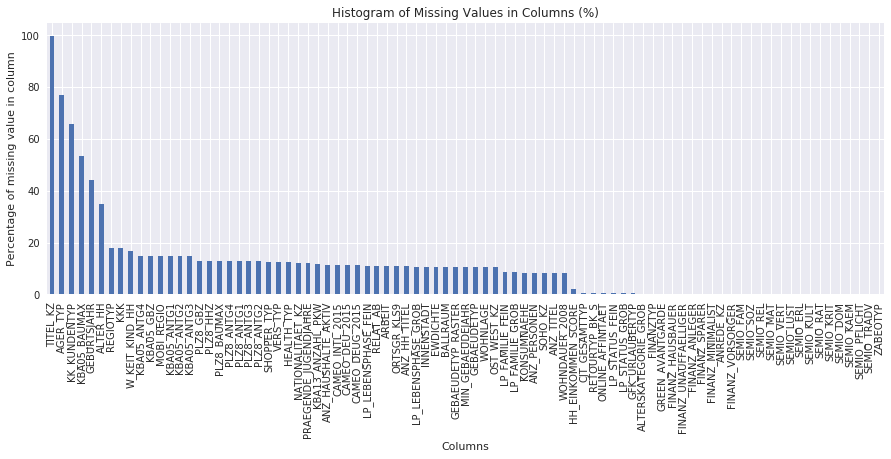

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
PLZ8_GBZ          13.073637
PLZ8_HHZ          13.073637
PLZ8_BAUMAX       13.073637
PLZ8_ANTG4        13.073637
PLZ8_ANTG1        13.073637
dtype: float64
['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
n_feat = azdias.shape[0]
missing = (azdias.isnull().sum(axis=0)/n_feat*100).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
missing.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Percentage of missing value in column')
plt.title('Histogram of Missing Values in Columns (%)')
plt.show()


print(missing.head(n=20))
#print(missing['LP_FAMILIE_GROB']) - 18
#print(missing['LP_STATUS_GROB']) - 0.5
#print(missing['CJT_GESAMTTYP']) - 0.5
missing_cols = missing[missing>18].index.tolist()
print(missing_cols)


In [6]:
# Investigate patterns in the amount of missing data in each column.
# Visualize the missing data by each data group.

ind = missing.value_counts().index
val = missing.value_counts().values

for i in range(12):
    print("Percentage Missing: ",ind[i], ". Number of columns: ",val[i])
    print(missing[missing==ind[i]].index)

azdias1 = azdias.drop(missing_cols,axis = 1)

Percentage Missing:  0.0 . Number of columns:  24
Index(['FINANZTYP', 'GREEN_AVANTGARDE', 'FINANZ_HAUSBAUER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER', 'FINANZ_SPARER',
       'FINANZ_MINIMALIST', 'ANREDE_KZ', 'FINANZ_VORSORGER', 'SEMIO_FAM',
       'SEMIO_SOZ', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')
Percentage Missing:  13.0736371787 . Number of columns:  7
Index(['PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1',
       'PLZ8_ANTG3', 'PLZ8_ANTG2'],
      dtype='object')
Percentage Missing:  0.544646052999 . Number of columns:  6
Index(['CJT_GESAMTTYP', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP'],
      dtype='object')
Percentage Missing:  14.9597013535 . Number of columns:  6
Index(['KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05

#### Discussion 1.1.2: Assess Missing Data in Each Column
"Are there any patterns in missing values? Which columns were removed from the dataset?"

Most of the data related to person level features has been collected. Person-Level features has 6 columns with 0.54% missing features. This is the most number of columns having the same number of missing features. It consists of columns CJT_GESAMTTYP, RETOURTYP_BK_S,ONLINE_AFFINITAET,LP_STATUS_FEIN, LP_STATUS_GROB and GFK_URLAUBERTYP.

These attributes may be related. The return type, online affinity and vacation habits of a customer determine their social status. LP_STATUS_GROB is dependent on LP_STATUS_FEIN as it is mapped directly from that. 


- PLZ8 Macro-cell has 7 columns with 13.07% missing values
Except for number of cars, all other columns have same number of missing values. Number of buildings unknown means number of households is unknown as well as the number of family houses in this region.

- RR3 Micro-Cell has 6 columns with 14.96% missing features : 
In these records KBA05* is NaN which means number of family houses in the microcell is unknown for certain records. Movement pattern is probably unknown for it as well.  

- Building level features has 4 columns with 10.45% missing features
This occurs when not much is known about the building like - when it was first mentioned in the database, how the neighbourhood is, what side the building is facing etc. 

- Household features has 4 columns with 8.25% missing features
MIN_GEBAEUDEJAHR    10.451729
GEBAEUDETYP         10.451729
WOHNLAGE            10.451729
OST_WEST_KZ         10.451729

- RR4 Micro-cell has 3 columns with 11.15% missing features
All columns at this level have the same number of missing values - the wealth/life stage typology is unknown at an International, German (rough), German (fine) level.

- Post Code level has 3 columns with 10.52% missing features.
All columns at the post code level have same number of NaNs. 

(>50 % missing columns)
There is no sense in imputing when over half the values are missing.
- TITEL_KZ has over 99.8% missing observations so it can't be used.
- AGER_TYP classifies the elderly. But we can get a similar classification of the individual from other attributes.
- KK_KUNDENTYP relates to consumer patterns over past 12 months. Most customers haven't been customers for a year which is why there is over 65% missing data. Missing information of these customers could likely be any of the 6 values so there is no sense in imputing. 
- KBA05_BAUMAX - The most common building type can be inferred from the columns relating to the different types of building type - (KBA05_ANTG* columns) 

(<50 and >18 % missing columns)
['GEBURTSJAHR', 'ALTER_HH'] - From these two - birth date sounds very useful but too many missing values to be useful. Birthdate of head of household is less useful when family type, and person related information is known. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

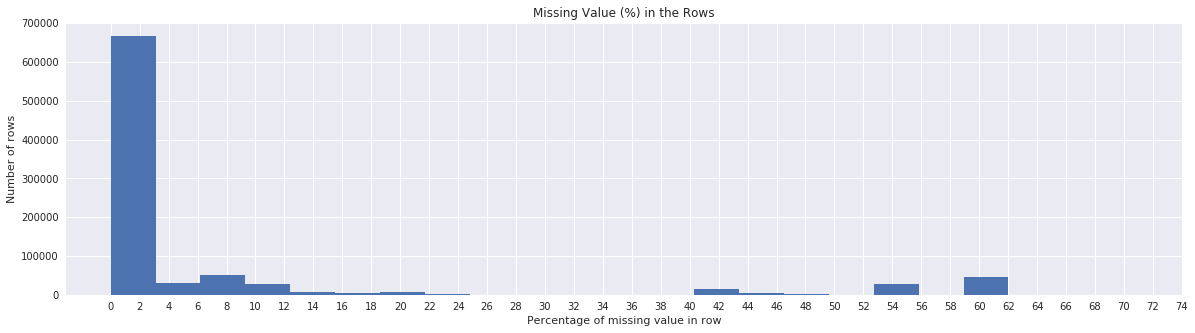

In [7]:
n_feat = azdias1.shape[1]
missing_rows = (azdias1.isnull().sum(axis=1)/n_feat*100) #.sort_values(inplace=True,ascending=False)
missing_rows.sort_values(inplace=True,ascending=False)

fig = plt.figure(figsize=(20,5))
plt.hist(missing_rows, bins=20)
plt.xlabel('Percentage of missing value in row')
plt.xticks(list(range(0,75,2)))
plt.ylabel('Number of rows')
plt.title('Missing Value (%) in the Rows')
plt.show()

In [8]:
missb13 = azdias1[azdias1.isnull().sum(axis=1) < 13]
missa13 = azdias1[azdias1.isnull().sum(axis=1) >= 13]

print("% of row having below 13 missing values: ",missb13.shape[0]/azdias.shape[0])
print("% of row having >= 13 missing values: ", missa13.shape[0]/azdias.shape[0])

% of row having below 13 missing values:  0.8774995203209979
% of row having >= 13 missing values:  0.12250047967900218


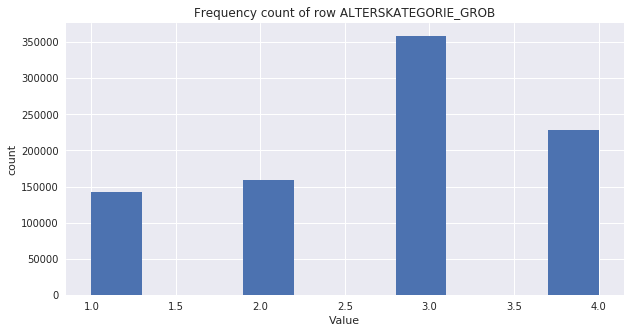

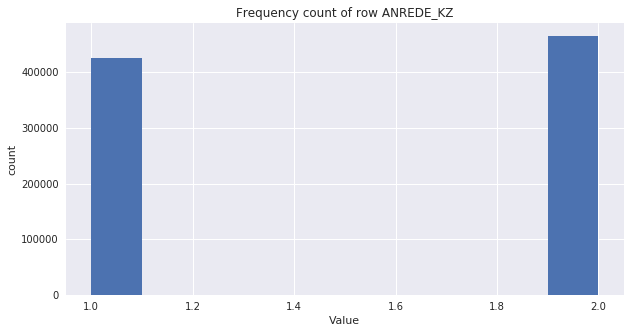

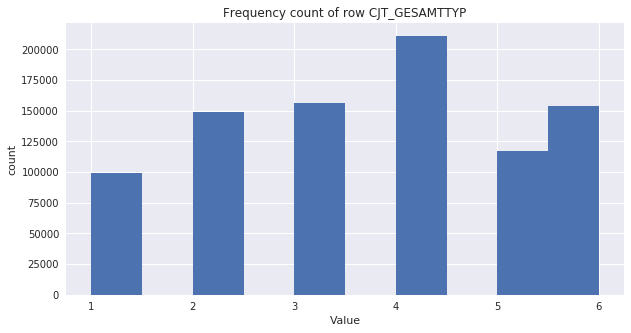

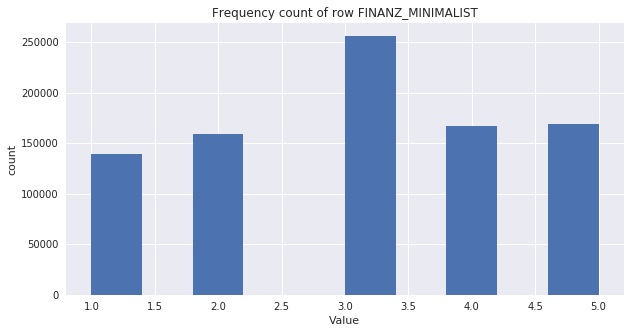

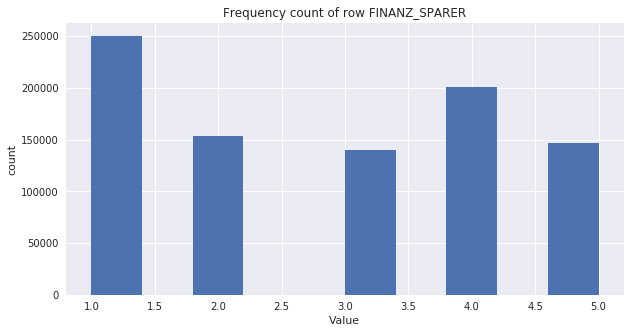

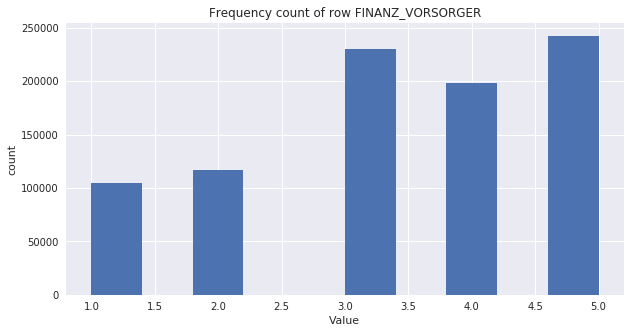

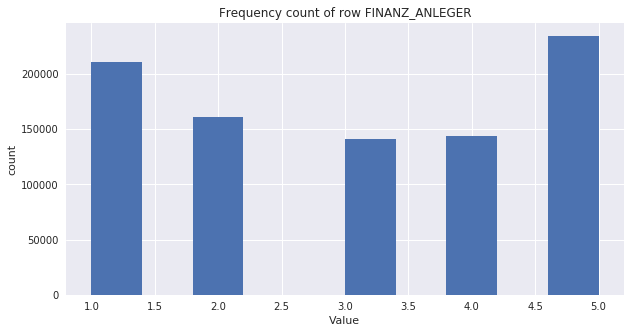

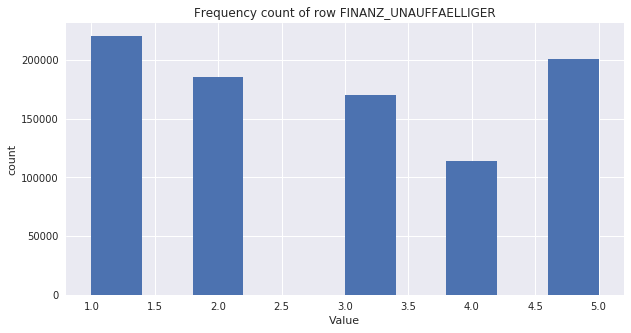

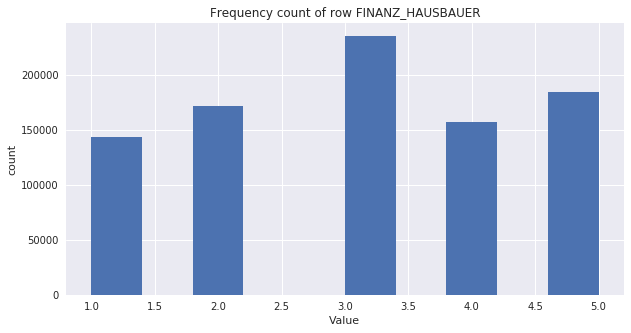

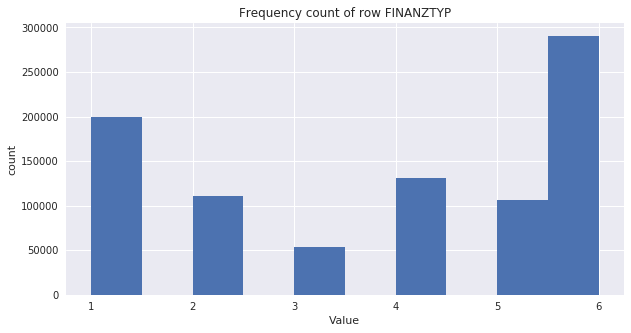

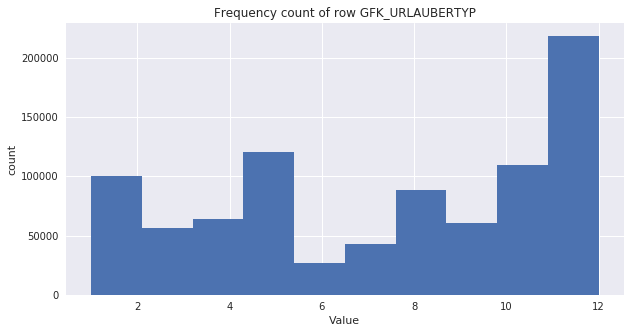

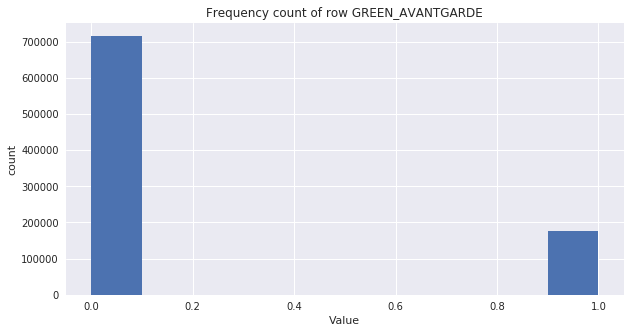

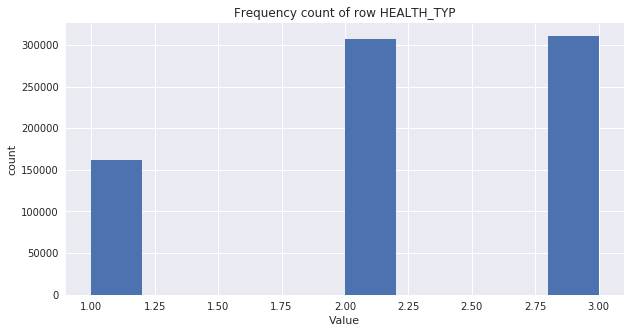

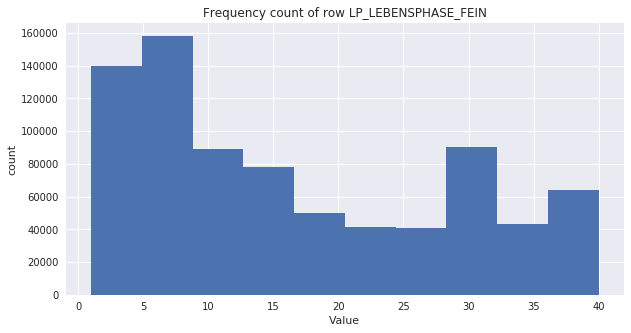

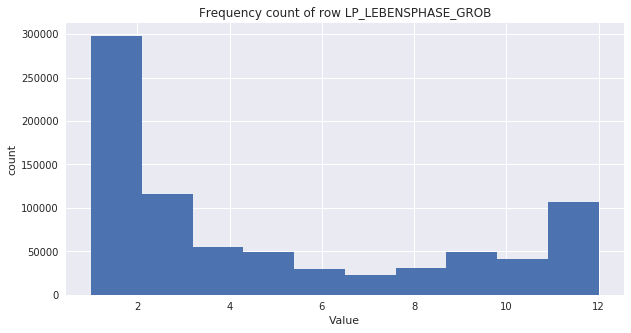

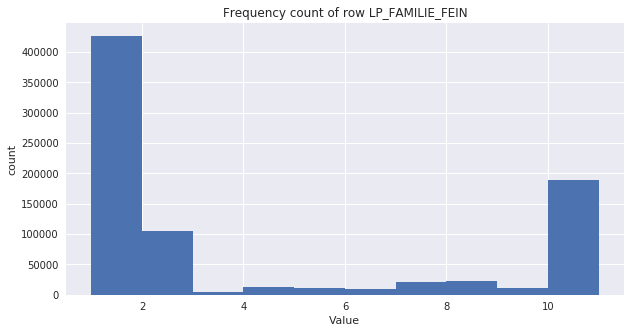

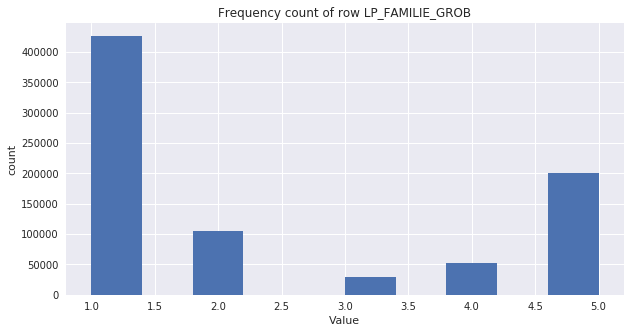

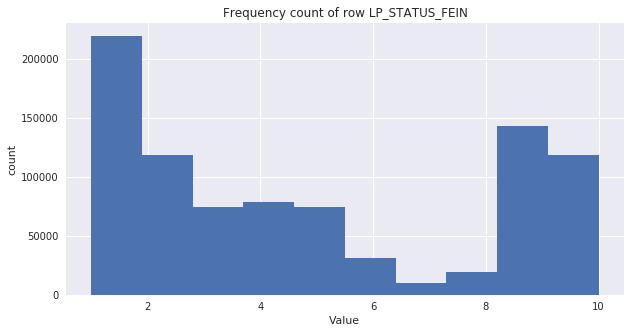

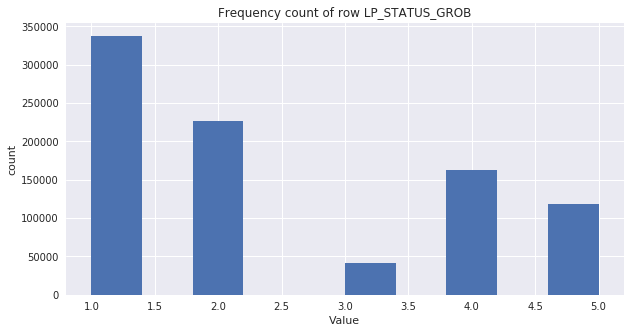

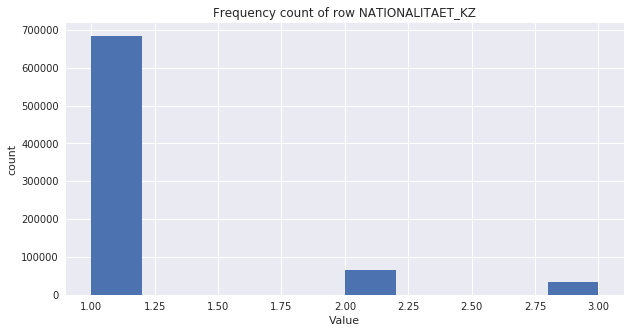

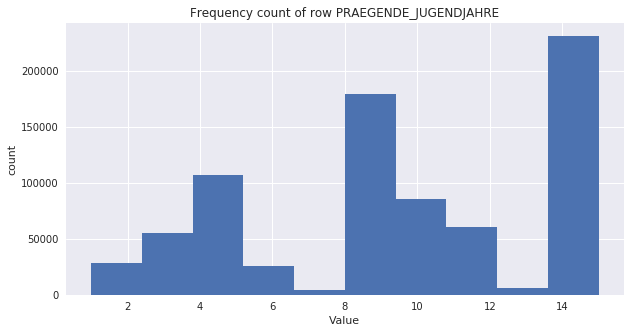

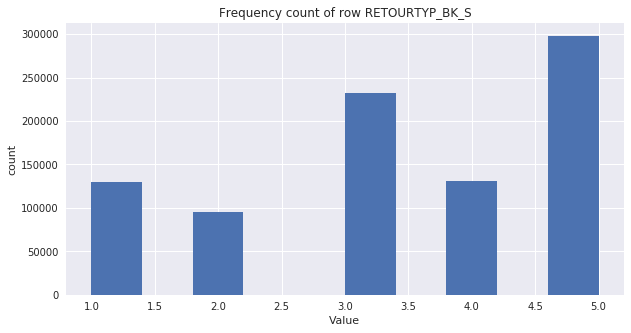

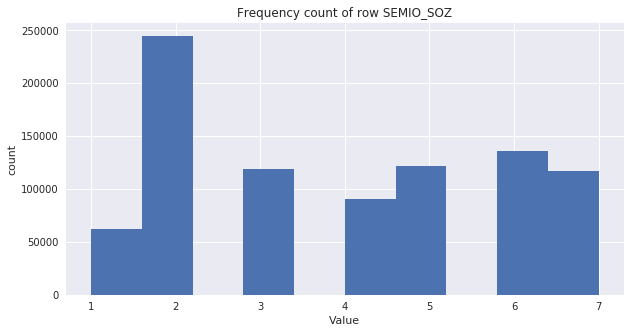

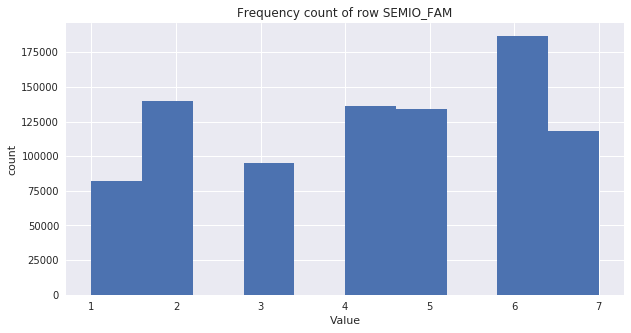

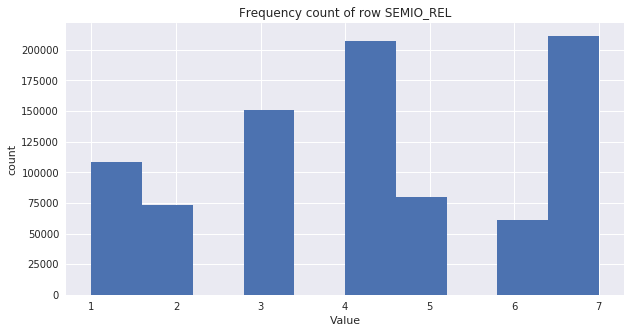

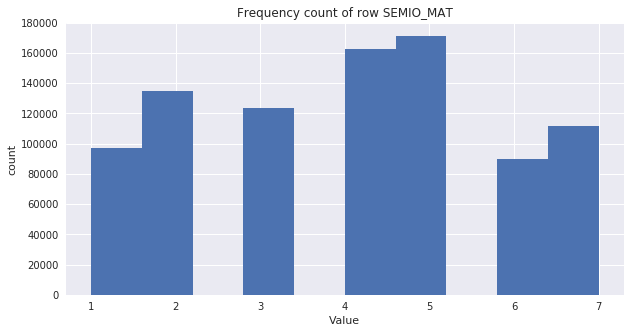

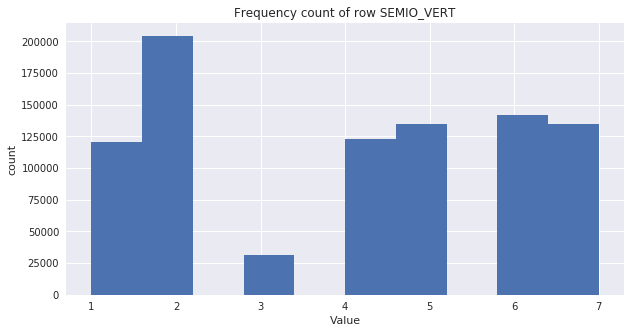

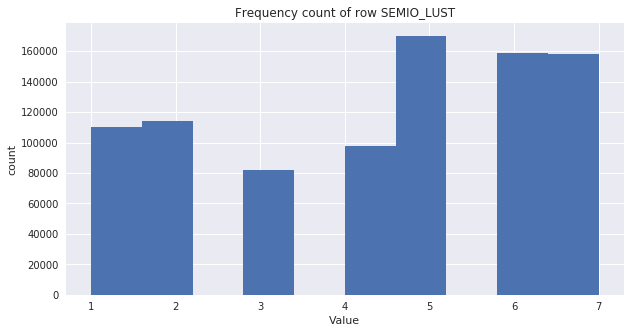

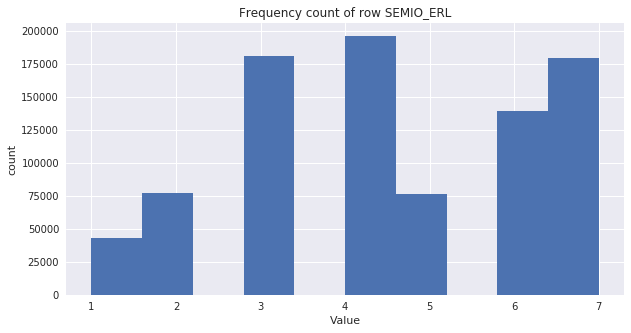

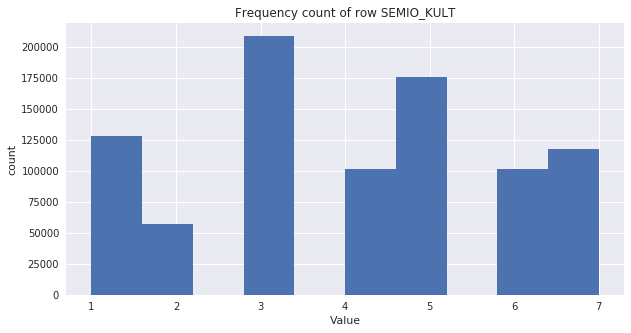

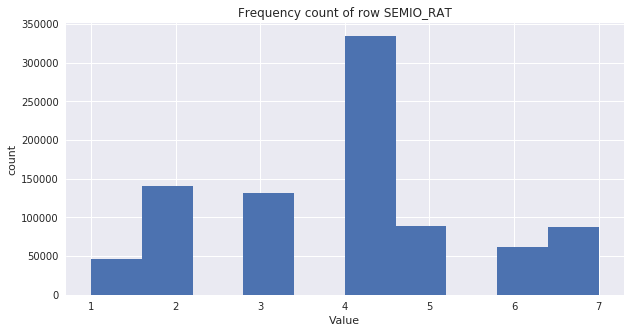

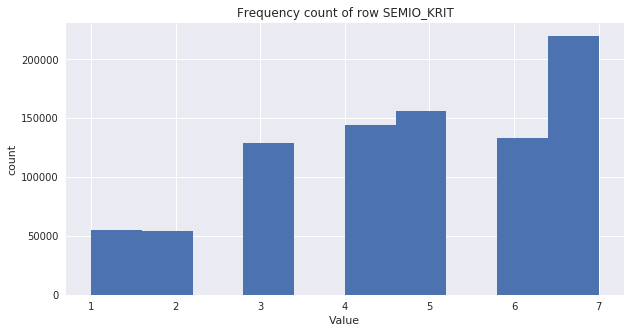

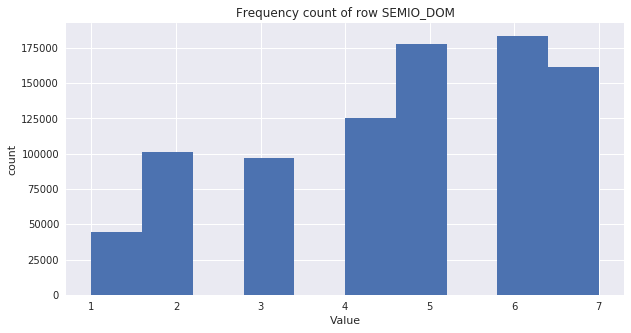

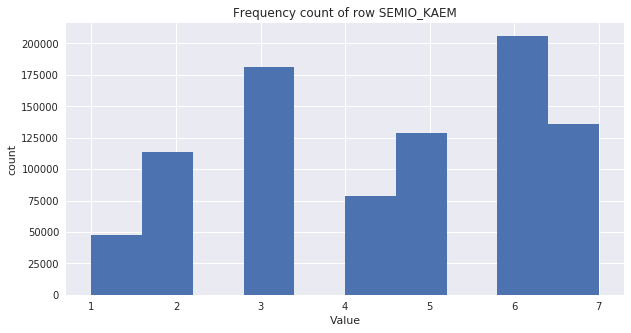

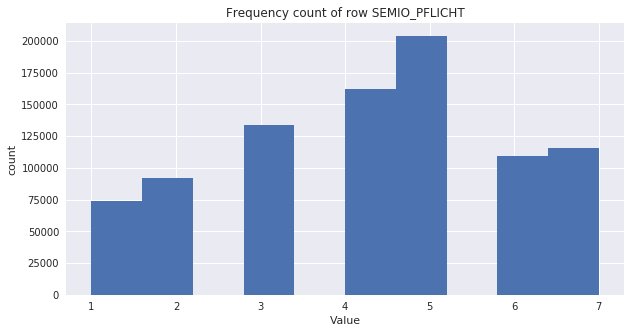

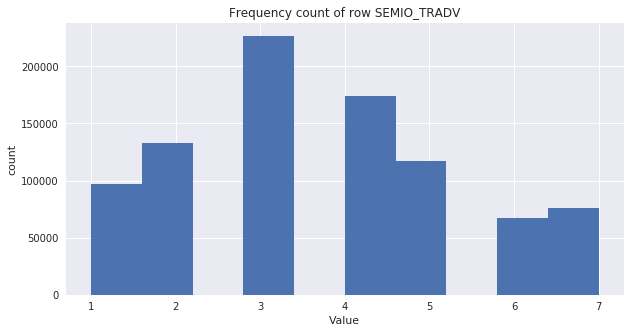

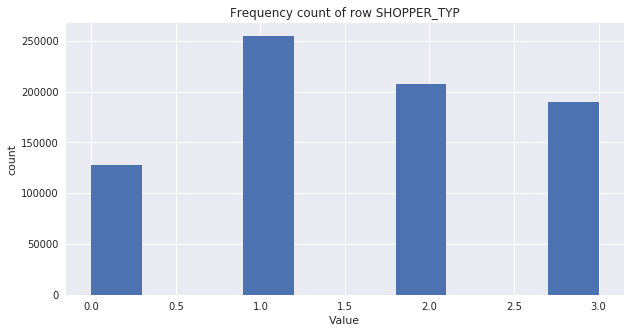

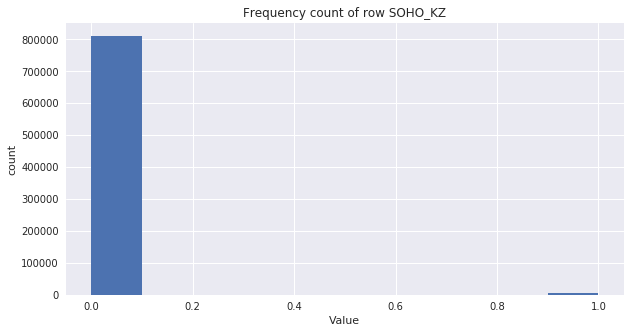

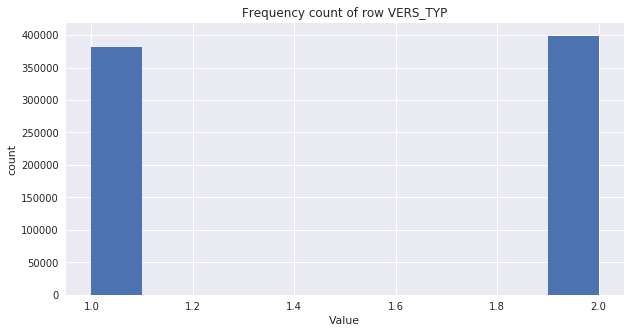

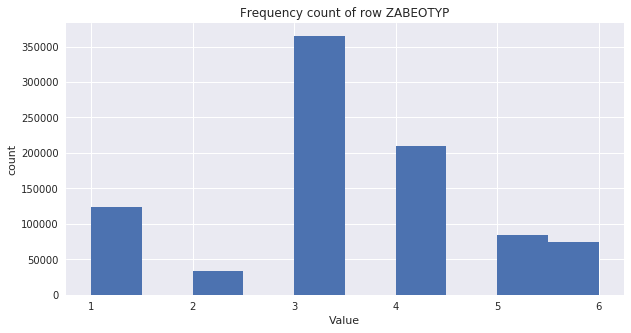

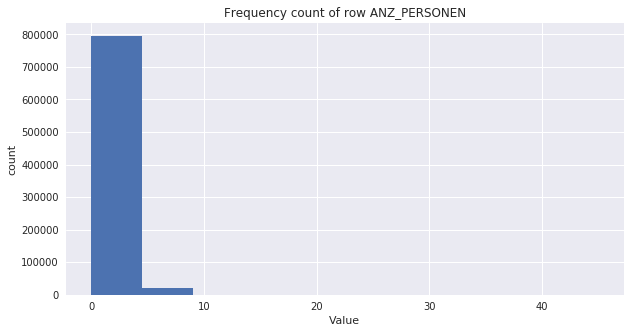

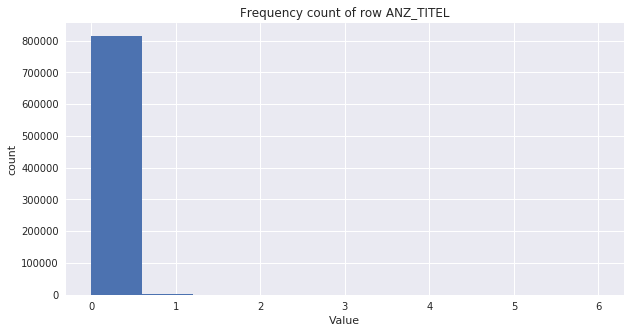

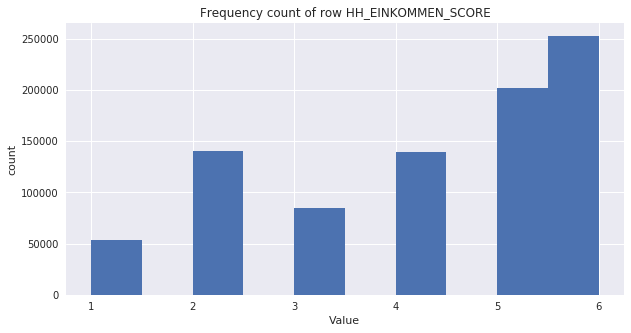

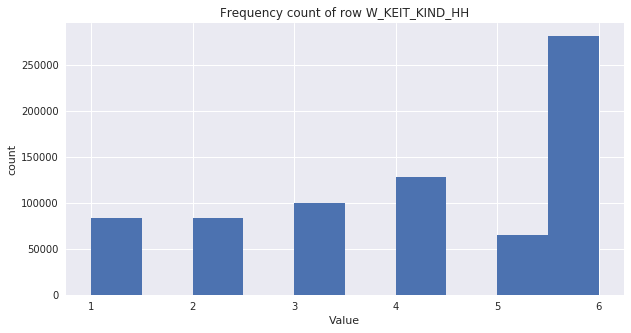

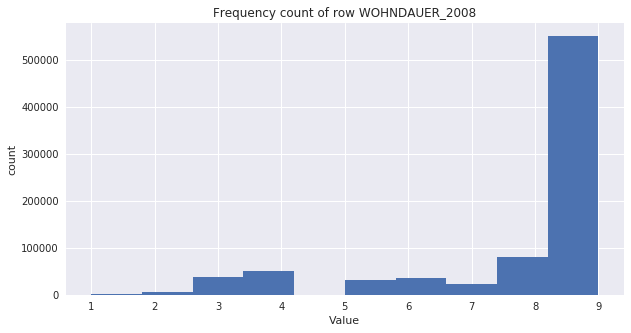

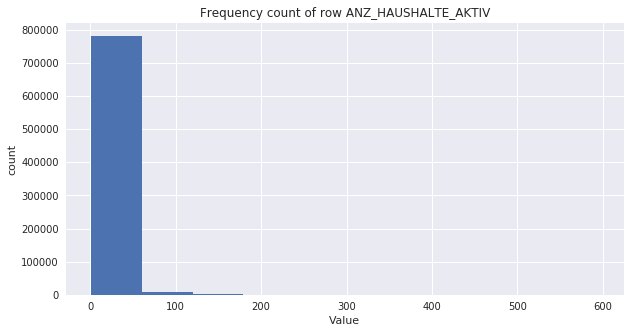

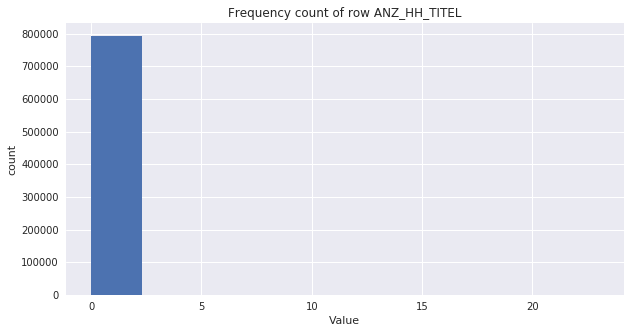

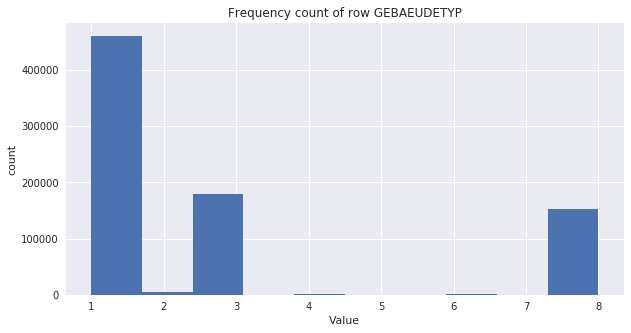

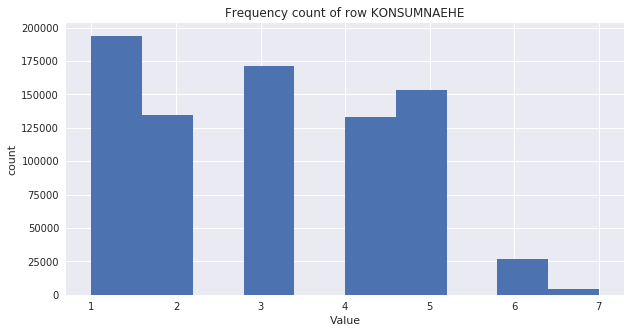

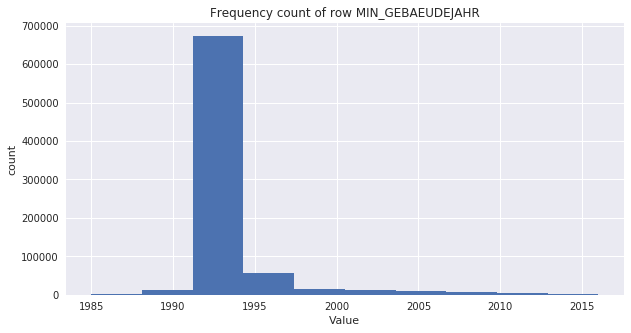

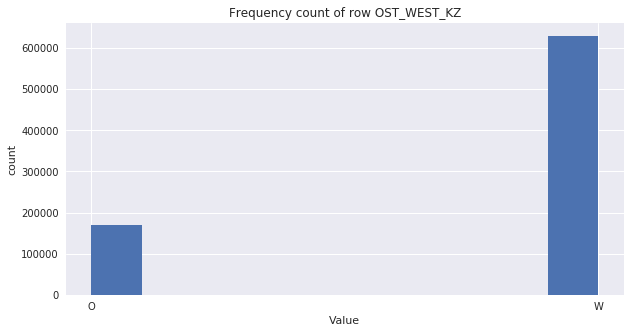

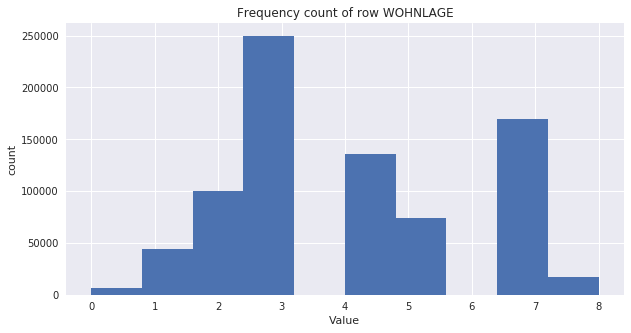

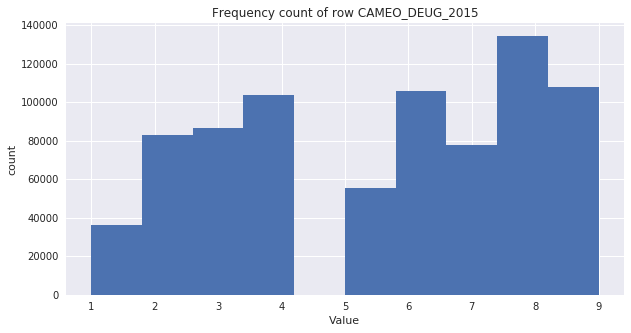

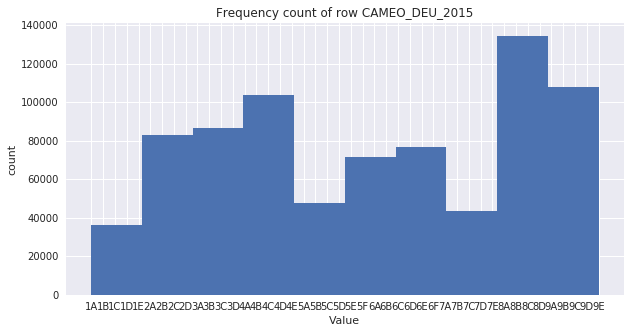

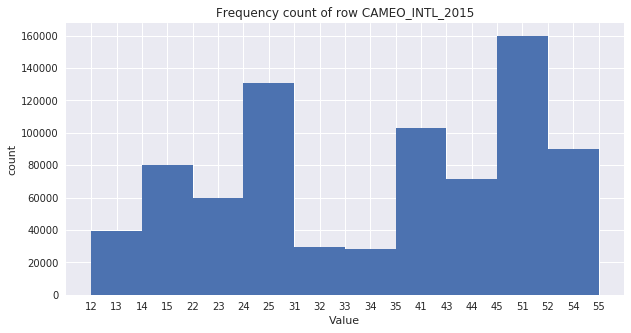

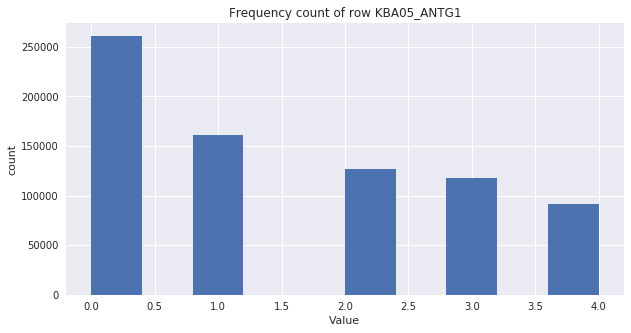

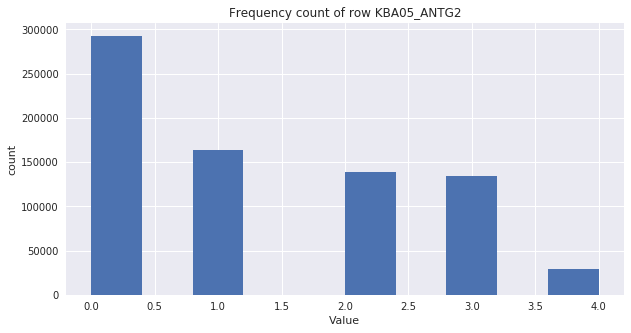

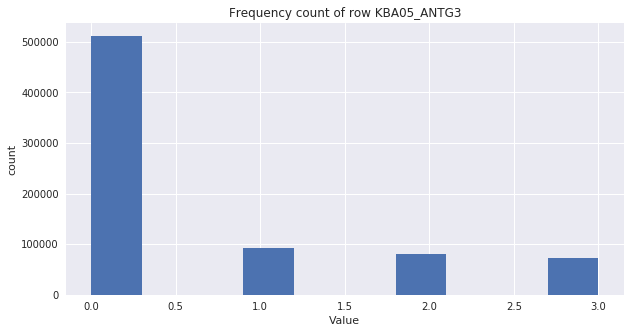

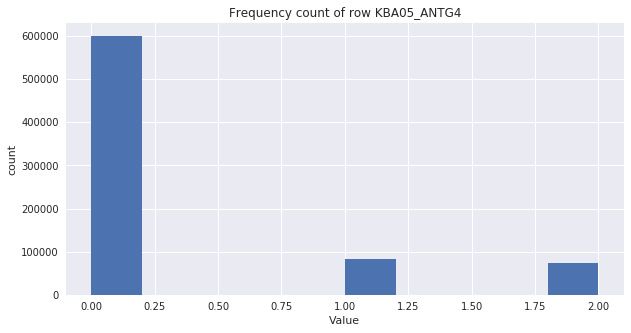

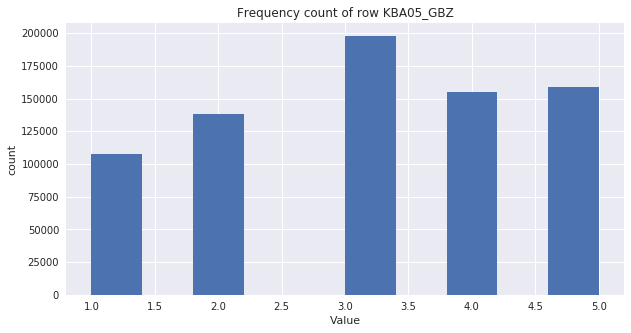

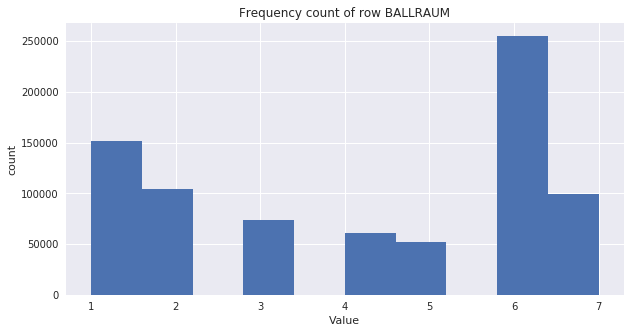

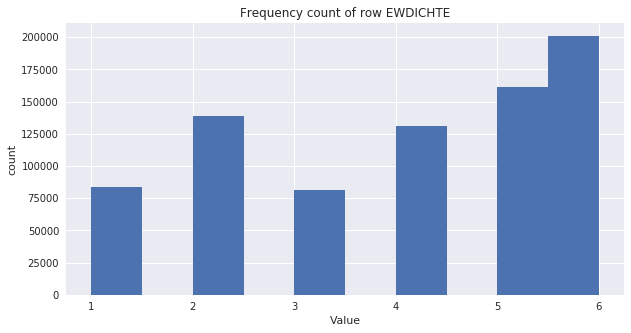

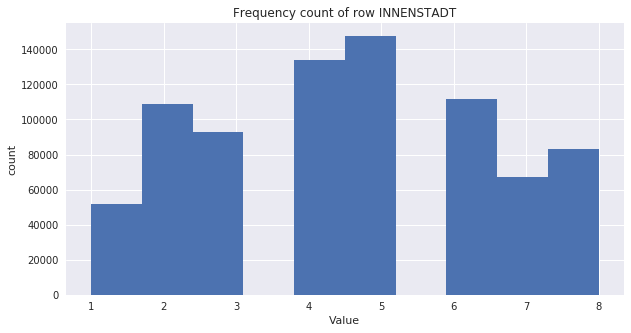

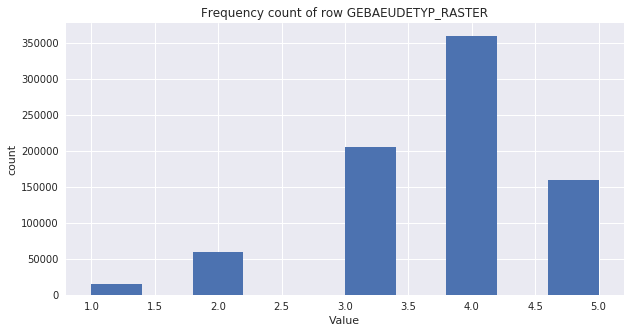

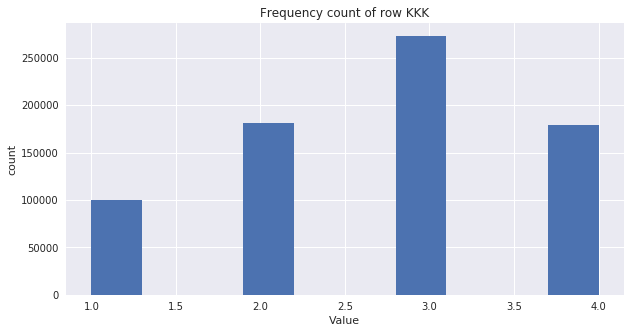

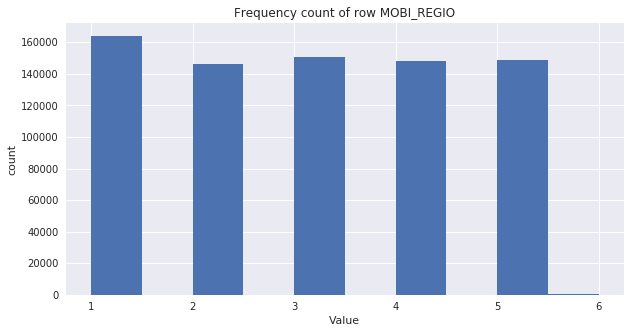

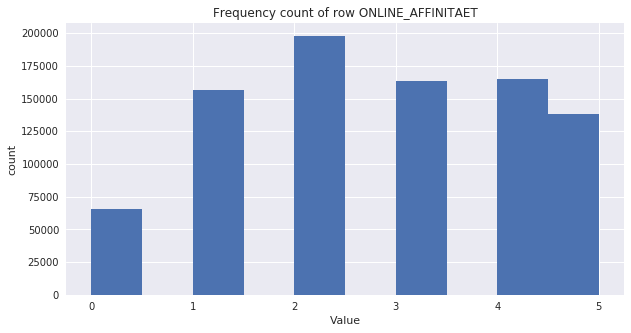

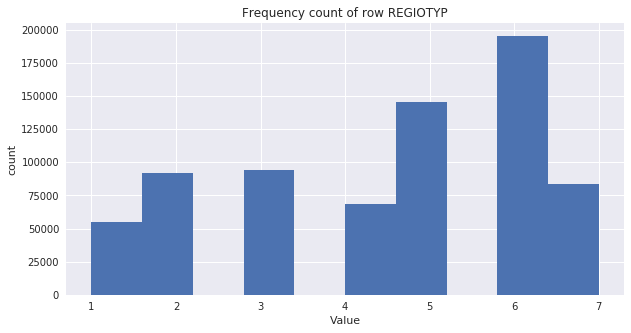

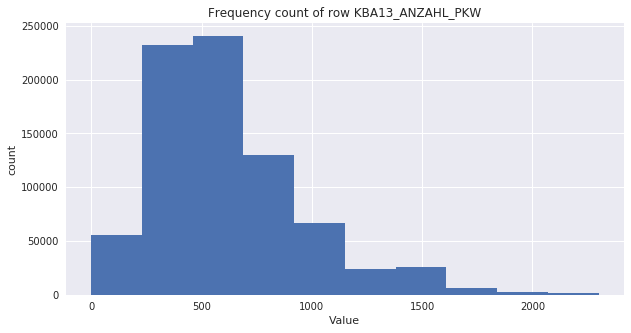

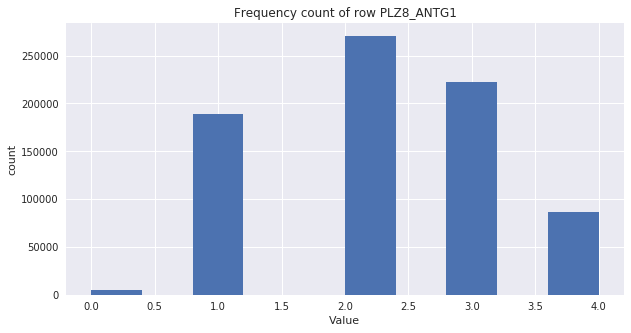

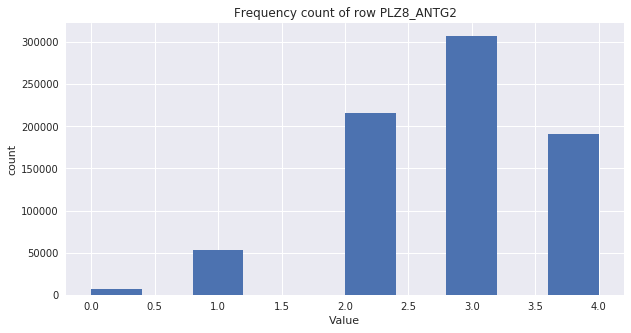

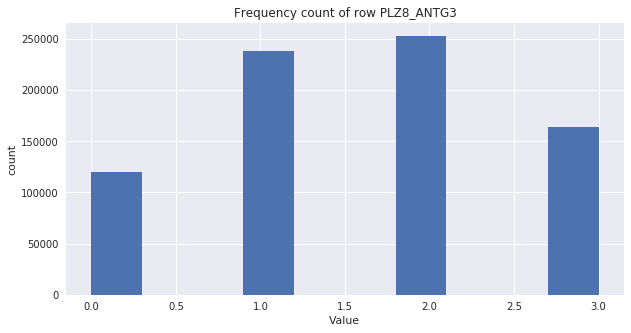

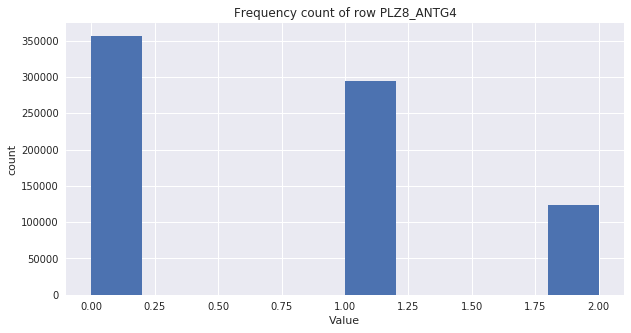

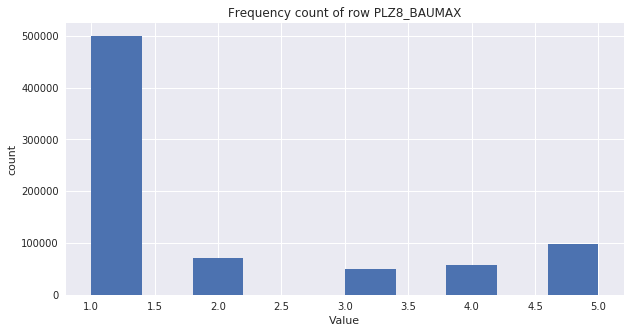

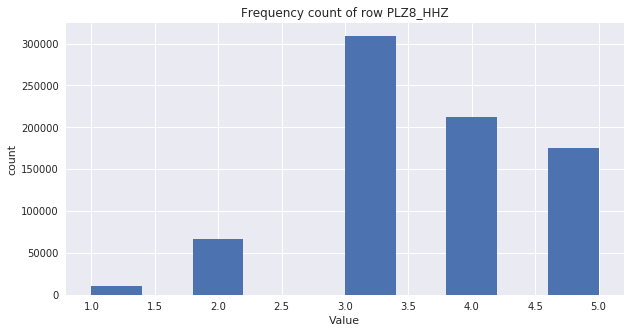

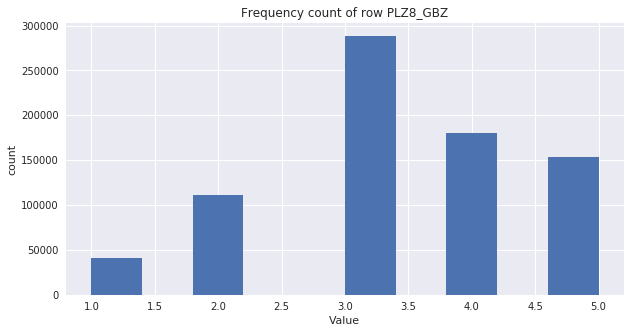

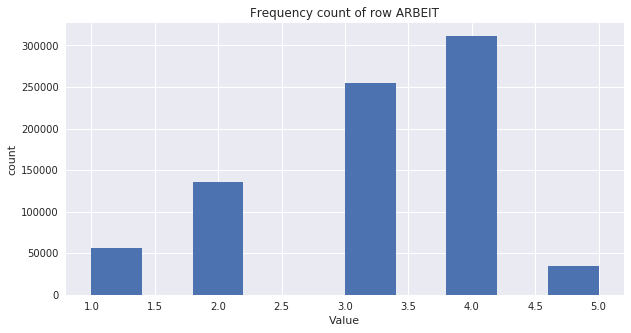

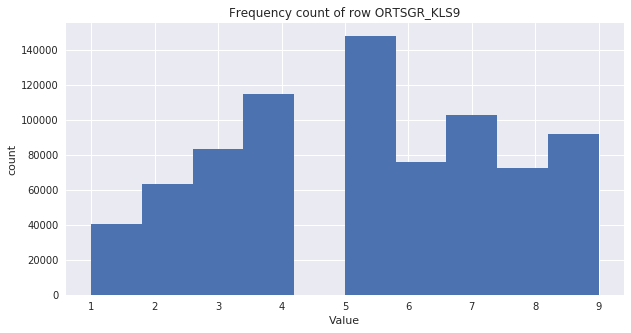

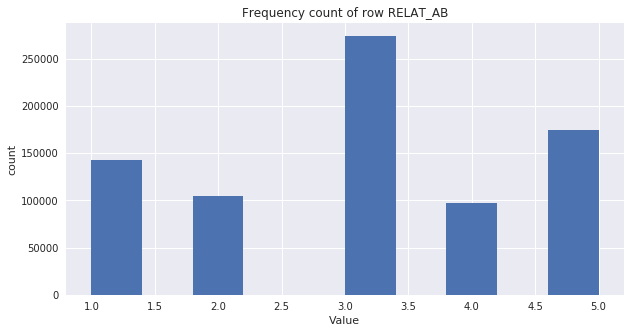

In [9]:
for i in missb13.columns:
    sns.set(font_scale=1)
    fig = plt.figure(figsize=(10,5))
    plt.hist(azdias[i].dropna())
    plt.xlabel('Value')
    plt.ylabel('count')
    plt.title('Frequency count of row ' + i)
    plt.show()

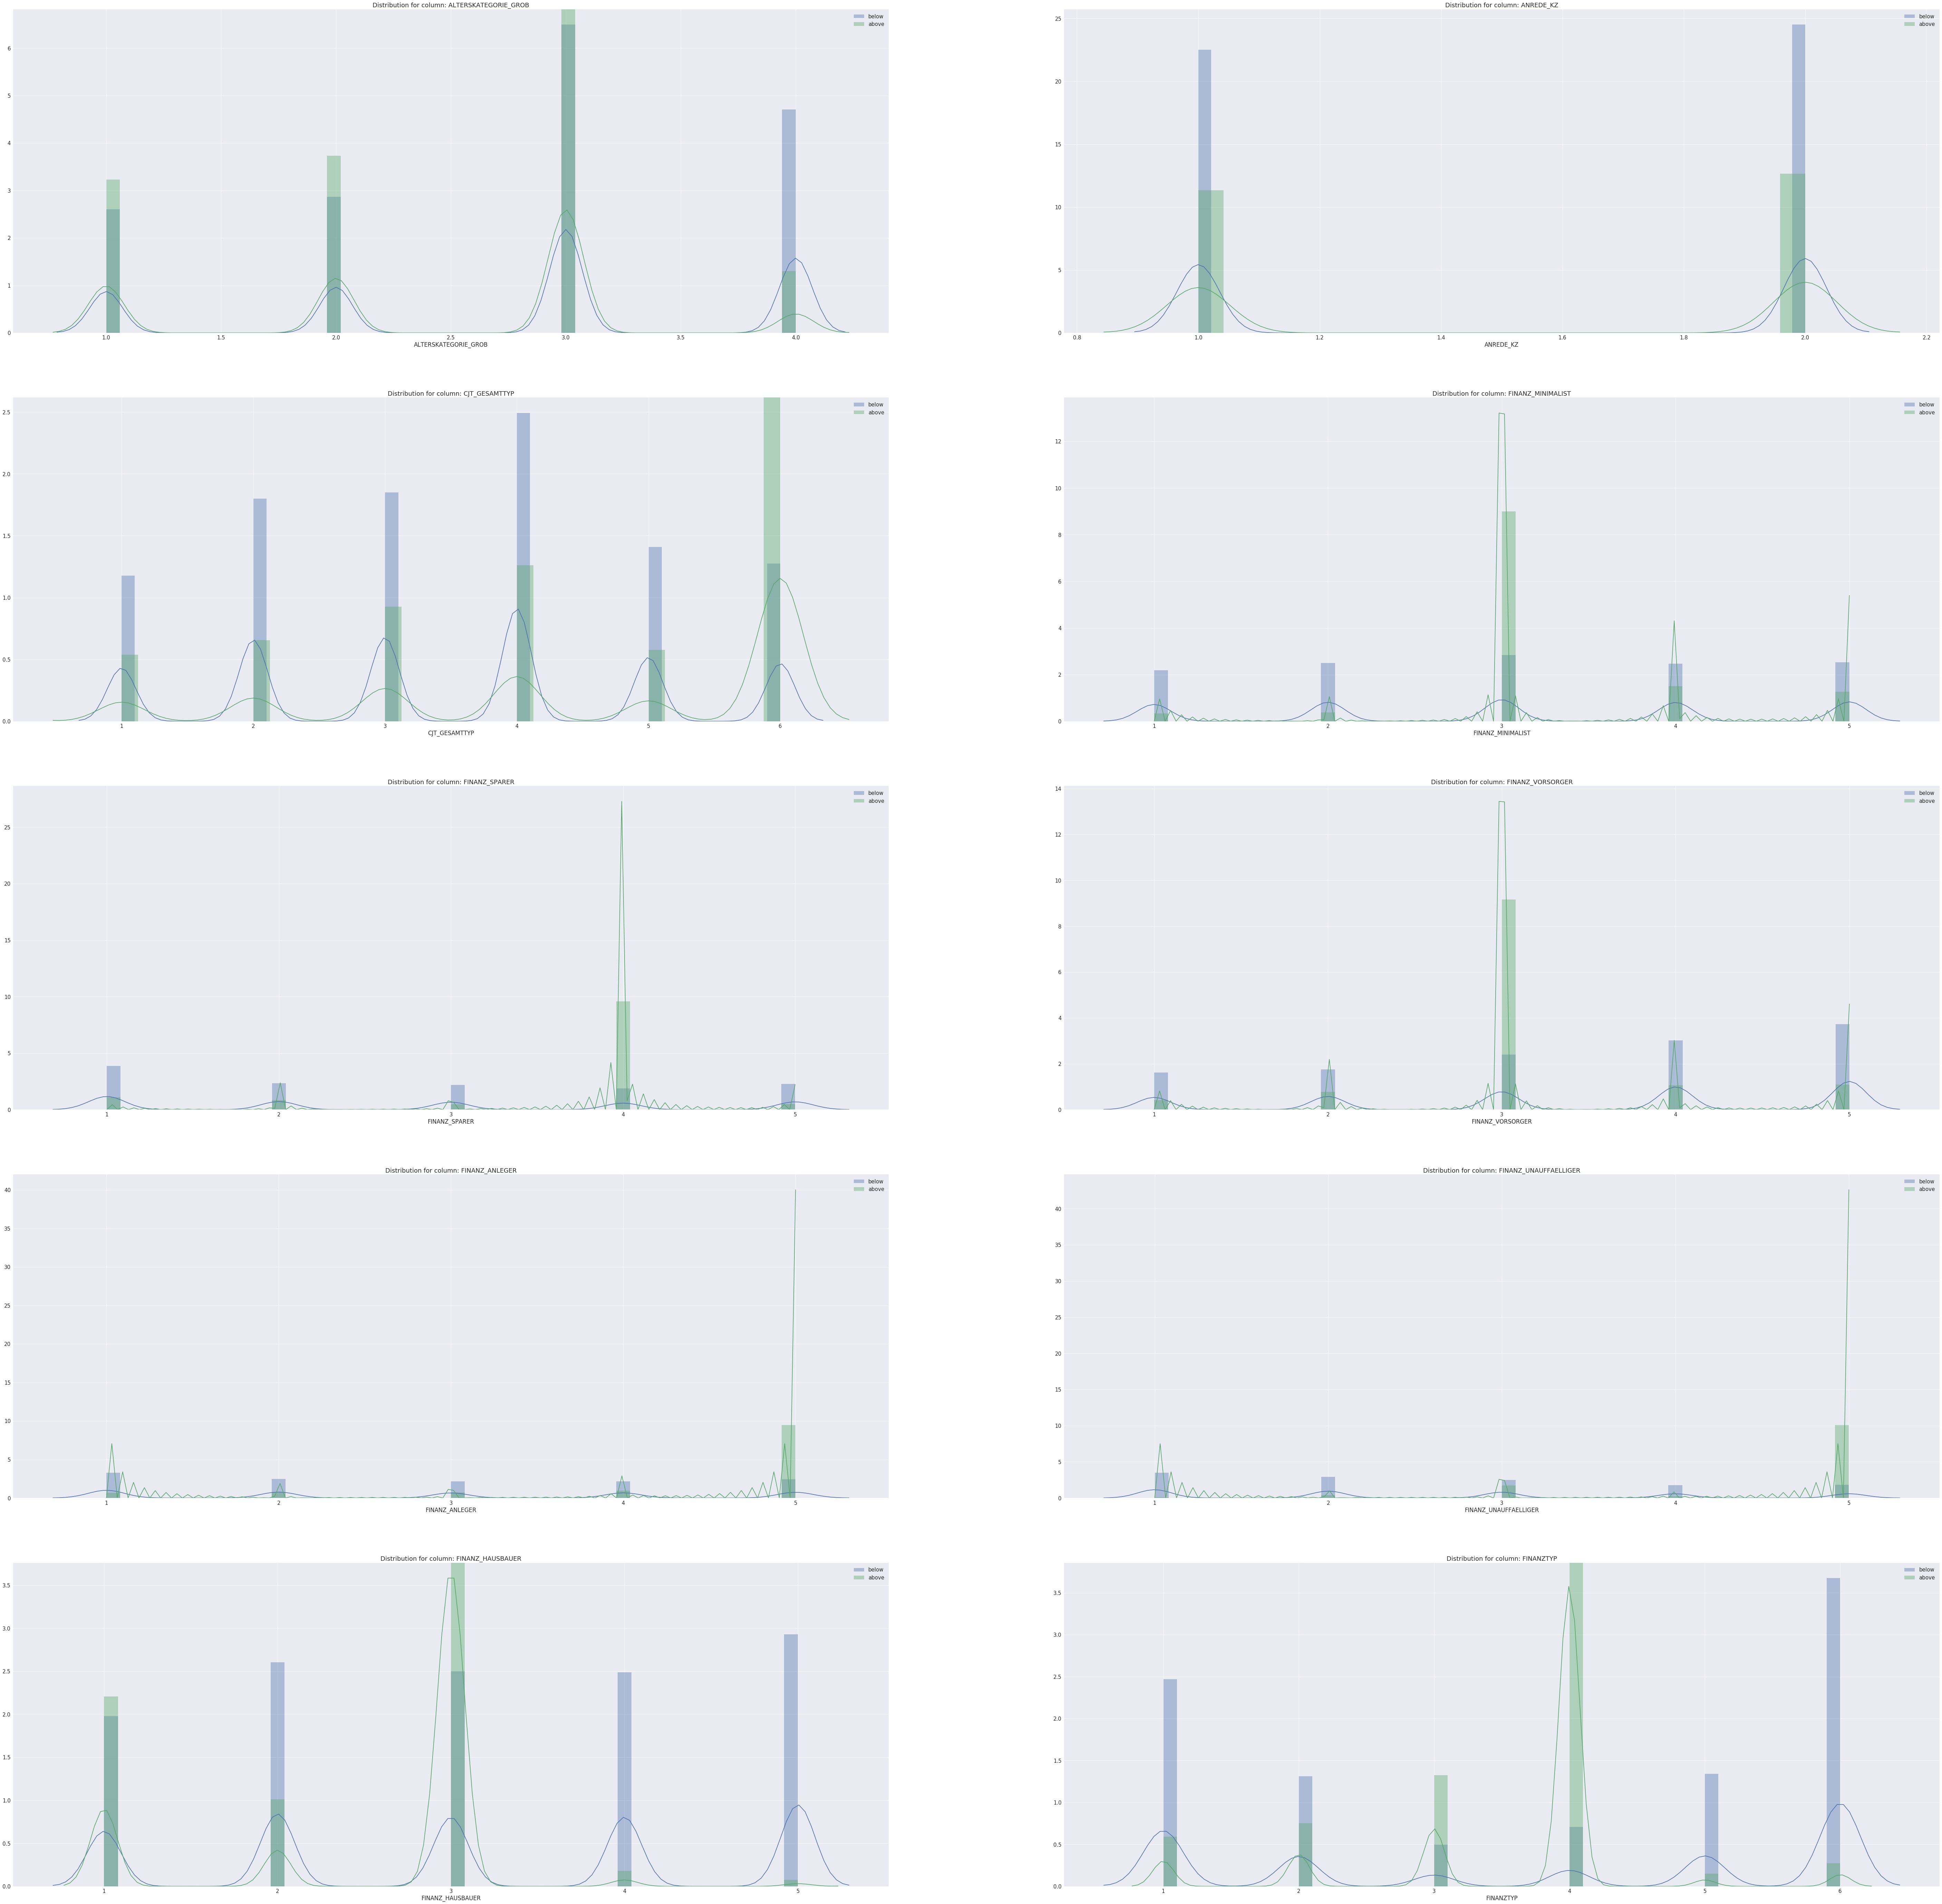

In [10]:
plt.figure(figsize=(100,100))
#i = 0
sns.set(font_scale=1.5)
for i,col in enumerate(azdias1.columns[:10]):
    val1 = missb13[col].notnull()
    val2 = missa13[col].notnull()
    plt.subplot(5,2,i+1)    
    sns.distplot(missb13[col][val1], label='below')
    sns.distplot(missa13[col][val2], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

In [11]:
for i in azdias1.columns:
    missb13[i].fillna(missb13[i].mode()[0],inplace=True) #made change here@@
azdias1 = missb13

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### Discussion 1.1.3: Assess Missing Data in Each Row

If we look at the first histogram most rows have <13 missing values. If we divide based on rows having < or >= 13 values we can see the histograms are distibuted more or less similarily. 

Hence, the few rows having over 13 columns of missing values can be dropped. If we removed rows where there was a value missing in the other category, a lot of informantion would be lost. This is why I filled the NAs using the most frequent value in the column. This method is used instead of mean() as most data isn't numerical. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# How many features are there of each data type?
feat_info1 = feat_info[feat_info['attribute'].isin(azdias1.columns.tolist())] 
print(feat_info.shape,feat_info1.shape)
print(feat_info1['type'].value_counts())

ordinal_cols = feat_info1[feat_info1['type']=='ordinal'].attribute.tolist() 
print("Ordinal Columns: ", ordinal_cols)

mixed_cols = feat_info1[feat_info1['type']=='mixed'].attribute.tolist() 
print("\nMixed Columns: " ,mixed_cols)

numerical_cols = feat_info1[feat_info1['type']=='numeric'].attribute.tolist() 
print("\nNumerical Columns: " ,numerical_cols)

categorical_cols = feat_info1[feat_info1['type']=='categorical'].attribute.tolist() 
print("\nCategorical Columns: " ,categorical_cols)

#earlier 49 (ordinal), 18(categorical), 6 (mixed), 6 (numeric) #now same

(85, 4) (79, 4)
ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64
Ordinal Columns:  ['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']

Mixed Columns:  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', '

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
print(len(categorical_cols))
drop_cat_col = []
encode_cat_col = []
for col in categorical_cols:    
    print(azdias1[col].unique(),)  
    print(azdias1[col].value_counts())
    if(len(azdias1[col].unique())>2):
        #azdias1.drop(col,axis=1,inplace=True)
        drop_cat_col.append(col)
    else:
        encode_cat_col.append(col)
        print("Binary encode ",col)

18
[2 1]
2    407708
1    374338
Name: ANREDE_KZ, dtype: int64
Binary encode  ANREDE_KZ
[ 5.  3.  2.  4.  1.  6.]
4.0    197923
3.0    143893
2.0    139919
5.0    109564
6.0     99185
1.0     91562
Name: CJT_GESAMTTYP, dtype: int64
[1 6 5 2 4 3]
6    287384
1    193094
5    104793
2    102669
4     55202
3     38904
Name: FINANZTYP, dtype: int64
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.]
12.0    129942
10.0    101478
8.0      81937
11.0     74003
5.0      69963
4.0      60199
9.0      55834
3.0      52985
1.0      50198
7.0      40135
2.0      39806
6.0      25566
Name: GFK_URLAUBERTYP, dtype: int64
[0 1]
0    610042
1    172004
Name: GREEN_AVANTGARDE, dtype: int64
Binary encode  GREEN_AVANTGARDE
[  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
1.0     425379
10.0    127336
2.0      96272
11.0     48255
8.0      21353
7.0      18726
4.0      11265
5.0      10985
9.0      10294
6.0       7777
3.0       4404
Name: LP_FAMILIE_FEIN, dtype: int64
[ 3.  1.  5.  2. 

In [14]:
cat_encode = ['LP_STATUS_GROB','CJT_GESAMTTYP','LP_FAMILIE_GROB']
cat_drop = list(set(drop_cat_col) - set(cat_encode)) #Mult columns - cat to encode 
encode_cat_col.remove('OST_WEST_KZ')

print("At category level:- ")
print("Dropping features: " ,cat_drop)
print("Label Encoding: ['OST_WEST_KZ']")
print("One-Hot encoding binary features: ",encode_cat_col)
print("One-Hot Encoding other features: " ,cat_encode)

encode_cat_col += cat_encode #['ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP] #binary + cat to encode

azdias1['OST_WEST_KZ'] = azdias1['OST_WEST_KZ'].map({'O':0,'W':1}) 

azdias1 = pd.get_dummies(data = azdias1, columns=encode_cat_col) 
azdias1.drop(cat_drop,axis=1,inplace=True)

At category level:- 
Dropping features:  ['LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'SHOPPER_TYP', 'FINANZTYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'CAMEO_DEUG_2015']
Label Encoding: ['OST_WEST_KZ']
One-Hot encoding binary features:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
One-Hot Encoding other features:  ['LP_STATUS_GROB', 'CJT_GESAMTTYP', 'LP_FAMILIE_GROB']


#### Discussion 1.2.1: Re-Encode Categorical Features

I kept all binary variables and one hot encoded them as it won't lead to too many columns. For variables with over 2 levels the following ones were kept - 
- 'LP_STATUS_GROB' - The social status is an important feature as a customer. 
- 'CJT_GESAMTTYP - Customers buying habits would depend on where they get their informational from and medium of buying.
- 'LP_FAMILIE_GROB' - Family type also seems like a crucial habit in a person's purchasing patterns. 

These have missing data of ~0.5,0.5,10% respectively. 

Categorical values that were removed 

- 'NATIONALITAET_KZ' - The data was too skewed - most of it belonged to one category and missing data as well. 
- 'CAMEO_DEU_2015','CAMEO_DEUG_2015' - Too many categories and is similar to CAMEO_INTL_2015 - the international Wealth/Life Stage typology
- 'LP_FAMILIE_FEIN' - Information already covered in rough scsale. 
- 'GEBAEUDETYP' - 8 categories. KBA05_BAUMAX gives some similar information. 
- 'LP_STATUS_FEIN' - Already covered in rough scale category similar ot this.
- 'GFK_URLAUBERTYP' - 12 categories are too much to one hot encode for this problem. 
- 'SHOPPER_TYP' - Contained too much missing data to be of use.
- 'ZABEOTYP' - This had 6 categories and energy consumption can be determined roughly from GREEN_AVANTGARDE

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [15]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#Movement 1 - mainstream, 0 means avantgarate

azdias1['DECADE'] = azdias1['PRAEGENDE_JUGENDJAHRE'].map({1: 1, 2: 1, 3:2,4:2, 5: 3,\
                                                          6:3,7:3, 8:4, 9:4, 10:5,\
                                                         11:5,12:5, 13:5, 14: 6, 15:6})
azdias1['MOVEMENT'] = azdias1['PRAEGENDE_JUGENDJAHRE'].map({1: 1, 2: 0, 3:1,4:0, 5: 1,\
                                                          6: 0,7: 0, 8: 1, 9: 0, 10: 1,\
                                                         11: 0,12:1, 13: 0, 14: 1, 15: 0})


In [16]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def interval(x,val=1):
    if pd.isnull(x):
        return x
    else:
        return int((int(x)/val)%10)
    
azdias1['LIFE_STAGE'] = azdias1['CAMEO_INTL_2015'].apply(interval,args=(1,))
azdias1['WEALTH'] = azdias1['CAMEO_INTL_2015'].apply(interval,args=(10,))
#change wohnlage_rural - 1 if rural, else 0
azdias1['WOHNLAGE_RURAL'] = azdias1['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

print(azdias1[['PRAEGENDE_JUGENDJAHRE','DECADE','MOVEMENT']].head(n=5))
print(azdias1[['CAMEO_INTL_2015','WEALTH','LIFE_STAGE']].head(n=5))
print(azdias1[['WOHNLAGE','WOHNLAGE_RURAL']].head(n=5))



   PRAEGENDE_JUGENDJAHRE  DECADE  MOVEMENT
1                   14.0       6         1
2                   15.0       6         0
3                    8.0       4         1
4                    8.0       4         1
5                    3.0       2         1
  CAMEO_INTL_2015  WEALTH  LIFE_STAGE
1              51       5           1
2              24       2           4
3              12       1           2
4              43       4           3
5              54       5           4
   WOHNLAGE  WOHNLAGE_RURAL
1       4.0               0
2       2.0               0
3       7.0               1
4       3.0               0
5       7.0               1


In [17]:
#drop mixed
azdias1.drop(mixed_cols,axis=1,inplace=True) 

#### Discussion 1.2.2: Engineer Mixed-Type Features

Re-engineered:

'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' mixed columns are already re-engineered in the above steps by wealth/life style and decade/movement respectively. 

Dropped :
'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB' information is covered in columns relateing to social status, family type etc. 
'PLZ8_BAUMAX' - All the other PLZ8_ANTG* columns together provide this information so it is redundant. 

'WOHNLAGE' category is for neighbourhood quality or else rural flag. So I made it a binary flag. Rural neighborhood, new building in rural neighborhood (7,8) is classied as 1 rest as 0. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [18]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

for i in azdias1.columns:
    azdias1[i].fillna(azdias1[i].mode()[0],inplace = True) 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [19]:
def cameo_interval(x,val=1):
    if pd.isnull(x):
        return x
    else:
        return int((int(x)/val)%10)

def clean_data(df): #assumption feat_info global
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #1. Feat_INFO
    for index, row in feat_info.iterrows():
        k = row['attribute']
        parse = row['missing_or_unknown'][1:-1] #remove bracket
        lis = -1
        if len(parse) == 0:
            continue
        parse = " ".join(parse.split()) # remove spaces
        lis = parse.split(',') #get numbers
        for l in range(len(lis)):
            try:
                lis[l] = int(lis[l])
            except:
                pass
        #print(k," " ,lis)
        df[k].replace(lis,np.NaN,inplace = True)
    
    #2. Too many missing
    missing_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(missing_cols,axis=1,inplace=True)
    #3. Fill Mode
    for i in df.columns:
        df[i].fillna(df[i].mode()[0],inplace=True)
    #4 Categorical to Drop
    cat_to_drop = ['NATIONALITAET_KZ', 'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP', 'LP_STATUS_FEIN',\
                   'CAMEO_DEUG_2015', 'GFK_URLAUBERTYP', 'SHOPPER_TYP','ZABEOTYP','FINANZTYP']
    df.drop(cat_to_drop,axis=1,inplace=True)

    #5. Encoding
    cat_to_encode = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','LP_STATUS_GROB',\
                     'CJT_GESAMTTYP', 'LP_FAMILIE_GROB']

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O':0,'W':1}) 
    df = pd.get_dummies(data = df, columns = cat_to_encode)
    
    #6 Re-Engineer
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1: 1, 2: 1, 3:2,4:2, 5: 3,\
                                                          6:3,7:3, 8:4, 9:4, 10:5,\
                                                         11:5,12:5, 13:5, 14: 6, 15:6})
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map({1: 1, 2: 0, 3:1,4:0, 5: 1,\
                                                          6: 0,7: 0, 8: 1, 9: 0, 10: 1,\
                                                         11: 0,12:1, 13: 0, 14: 1, 15: 0})
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(cameo_interval,args=(1,))
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(cameo_interval,args=(10,))
    df['WOHNLAGE_RURAL'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    #7 Drop all mixed
    mixed_cols = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    df.drop(mixed_cols,axis=1,inplace=True)
    #fill remaining again
    for i in azdias1.columns:
        azdias1[i].fillna(azdias1[i].mode()[0],inplace = True) #made change here@@

    # Return the cleaned dataframe.
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [20]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(azdias1.values)
scaled_azdias = pd.DataFrame(scaled_features, index=azdias1.index, columns=azdias1.columns)
print(scaled_azdias.head(n=3))

   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1             -1.767872          -1.488579       1.539141         -1.045335   
2              0.198096          -1.488579       0.866589         -1.771766   
3              1.181080           0.688223      -0.478515          1.133958   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1        1.466874               0.979056          1.327541    1.005781   
2       -0.569222               0.261642          1.327541    1.005781   
3       -0.569222              -1.173185         -0.816561   -0.316594   

   RETOURTYP_BK_S  SEMIO_SOZ       ...        LP_FAMILIE_GROB_1.0  \
1       -1.682222   0.435314       ...                  -1.092085   
2       -0.309646  -0.079571       ...                   0.915679   
3       -0.995934   0.435314       ...                   0.915679   

   LP_FAMILIE_GROB_2.0  LP_FAMILIE_GROB_3.0  LP_FAMILIE_GROB_4.0  \
1            -0.374679             5.3235

### Discussion 2.1: Apply Feature Scaling


There are no NaN values. Rows with too many missing values (>=3) were removed and the remaining were filled with the mode of the respective columns. 

The dataframe is standardised by using a StandardScaler. I'm using standardisation instead of normalisation so outlier is not lost  - standard deviation is used as a reference.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

On our scaled data, we are now ready to apply dimensionality reduction techniques.

Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's plot() function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [21]:
# Apply PCA to the data.
pca = PCA()
pca.fit(scaled_azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

1   0.143641000199
2   0.106184569877
3   0.0818022269606
4   0.0558393207569
5   0.0330519579976
6   0.0278276059425
7   0.0267758800117
8   0.0241239657141
9   0.0235396034265
10   0.0222488330229
11   0.0189604788025
12   0.0183701665497
13   0.0164863132107
14   0.0160265092718
15   0.015333699366
16   0.0152148786395
17   0.0150100547615
18   0.0148390007795
19   0.0141860547245
20   0.013932893391
21   0.0132691870485
22   0.0130649618614
23   0.0128930266551
24   0.0122082111246
25   0.011743722035
26   0.0112819265855
27   0.0111984525405
28   0.0107937610946
29   0.0103502499142
30   0.00980208035607
31   0.00959523207844
32   0.00898418224323
33   0.00858312315322
34   0.00797932482743
34 components give variance >= 85%
35   0.00784066950218
35 components give variance >= 85%
36   0.00751939040122
36 components give variance >= 85%
37   0.00695309296605
37 components give variance >= 85%
38   0.00624586132859
38 components give variance >= 85%
39   0.00600641563483
39 compone

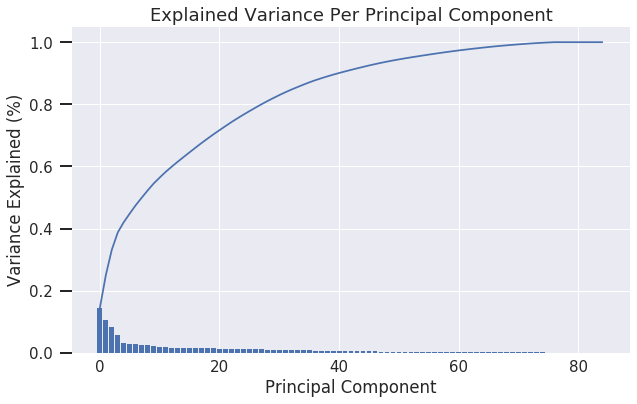

In [22]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)
varsum,i =0,0
for i in range(len(pca.explained_variance_ratio_)):
    print(i+1 , " " ,  pca.explained_variance_ratio_[i])
    varsum += pca.explained_variance_ratio_[i]
    if varsum ==1:
        print(i+1,"components give variance >= 100%",)
        break
    if varsum >= .95:
        print(i+1,"components give variance >= 95%",)
        #break
    elif varsum >=0.90:
        print(i+1,"components give variance >= 90%",)
    elif varsum >= 0.85:
        print(i+1,"components give variance >= 85%",)

print(pd.DataFrame(pca.components_,columns=scaled_azdias.columns).head(n=2)) #PCA1,PCA2 of each given between particular feature and component

In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.
print(scaled_azdias.shape)
pca1 = PCA(n_components=42) #i+1=42 changed from 41!!
scale1 = pca1.fit_transform(scaled_azdias)
scale1 = pd.DataFrame(scale1)
print(scale1.shape)

(782046, 85)
(782046, 42)


### Discussion 2.2: Perform Dimensionality Reduction

By looking at the plot above, we can see after 42 features explain 90% of the variance and contribute to atleaset 0.5% of the total variance. A total of 77 features explain 100% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [24]:
cums = []
cumsum= 0
for cum in pca1.explained_variance_ratio_:
    cumsum = cumsum + cum
    cums.append(cumsum)
varInfo = pd.DataFrame(list(zip(pca1.explained_variance_ratio_,cums)),columns=['Variance Ratio','Cumulative Variance Ratio'],index=['PC'+str(i+1) for i in range(42)]) #14,10 is evr
print(varInfo)

      Variance Ratio  Cumulative Variance Ratio
PC1         0.143641                   0.143641
PC2         0.106185                   0.249826
PC3         0.081802                   0.331628
PC4         0.055839                   0.387467
PC5         0.033052                   0.420519
PC6         0.027828                   0.448347
PC7         0.026776                   0.475123
PC8         0.024124                   0.499247
PC9         0.023540                   0.522786
PC10        0.022249                   0.545035
PC11        0.018960                   0.563995
PC12        0.018370                   0.582366
PC13        0.016486                   0.598852
PC14        0.016026                   0.614878
PC15        0.015334                   0.630212
PC16        0.015215                   0.645427
PC17        0.015010                   0.660437
PC18        0.014839                   0.675276
PC19        0.014186                   0.689462
PC20        0.013933                   0

In [25]:
def pca_weights(pca,comp):
    weights = []
    for i,feat in enumerate(azdias1.columns):
        weights.append([feat,pca.components_[comp][i]])
    weights = sorted(weights,key=lambda x: x[1],reverse=True)
    return weights  

In [26]:
map1 = pd.DataFrame(pca_weights(pca1,1),columns=['Feature','PCA-1'])
print(map1.head(n=5))

                Feature     PCA-1
0  ALTERSKATEGORIE_GROB  0.250668
1             SEMIO_ERL  0.238030
2      FINANZ_VORSORGER  0.225883
3            SEMIO_LUST  0.174658
4        RETOURTYP_BK_S  0.151935


In [27]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map2 = pd.DataFrame(pca_weights(pca1,2),columns=['Feature','PCA-2'])
print(map2.head(n=5))

       Feature     PCA-2
0  ANREDE_KZ_1  0.337326
1   SEMIO_VERT  0.313685
2    SEMIO_SOZ  0.233731
3    SEMIO_FAM  0.215323
4   SEMIO_KULT  0.198487


In [28]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map3 = pd.DataFrame(pca_weights(pca1,3),columns=['Feature','PCA-3'])
print(map3.head(n=5))

              Feature     PCA-3
0  GREEN_AVANTGARDE_1  0.361732
1  LP_STATUS_GROB_5.0  0.273585
2            EWDICHTE  0.221315
3         ORTSGR_KLS9  0.220889
4   ONLINE_AFFINITAET  0.122153


In [29]:
#INTERPRET PCA PROPERLY
mapComb = pd.merge(pd.merge(map1,map2,on='Feature'),map3,on='Feature') #merge all 3 
mapComb.sort_values(by=['PCA-1'],ascending=False,inplace=True)
print("Positve and Negatives of PCA-1")
print(mapComb.head(n=5))
print(mapComb.tail(n=5))
print("\nPositve and Negatives of PCA-2")
mapComb.sort_values(by=['PCA-2'],ascending=False,inplace=True)
print(mapComb.head(n=5))
print(mapComb.tail(n=5))
print("\nPositve and Negatives of PCA-3")
mapComb.sort_values(by=['PCA-3'],ascending=False,inplace=True)
print(mapComb.head(n=5))
print(mapComb.tail(n=5))

Positve and Negatives of PCA-1
                Feature     PCA-1     PCA-2     PCA-3
0  ALTERSKATEGORIE_GROB  0.250668  0.094472 -0.042868
1             SEMIO_ERL  0.238030 -0.143550 -0.009237
2      FINANZ_VORSORGER  0.225883  0.108445 -0.026862
3            SEMIO_LUST  0.174658  0.072538 -0.002738
4        RETOURTYP_BK_S  0.151935  0.114779 -0.010768
          Feature     PCA-1     PCA-2     PCA-3
80  SEMIO_PFLICHT -0.222535 -0.093030  0.022886
81  FINANZ_SPARER -0.230484 -0.113218  0.015800
82     SEMIO_KULT -0.233484  0.198487 -0.032970
83         DECADE -0.235717 -0.118607  0.037898
84      SEMIO_REL -0.257599  0.042209 -0.003274

Positve and Negatives of PCA-2
        Feature     PCA-1     PCA-2     PCA-3
71  ANREDE_KZ_1 -0.114066  0.337326 -0.050790
70   SEMIO_VERT -0.089280  0.313685 -0.032011
72    SEMIO_SOZ -0.119928  0.233731 -0.002832
77    SEMIO_FAM -0.198952  0.215323 -0.028942
82   SEMIO_KULT -0.233484  0.198487 -0.032970
        Feature     PCA-1     PCA-2     PCA-3
73 

In [30]:
print(varInfo.join(pd.DataFrame(pca1.components_,columns=azdias1.columns,index=['PC'+str(i+1) for i in range(42)])))

      Variance Ratio  Cumulative Variance Ratio  ALTERSKATEGORIE_GROB  \
PC1         0.143641                   0.143641             -0.099140   
PC2         0.106185                   0.249826              0.250668   
PC3         0.081802                   0.331628              0.094472   
PC4         0.055839                   0.387467             -0.042868   
PC5         0.033052                   0.420519              0.051669   
PC6         0.027828                   0.448347              0.007345   
PC7         0.026776                   0.475123              0.053800   
PC8         0.024124                   0.499247             -0.013779   
PC9         0.023540                   0.522786             -0.003469   
PC10        0.022249                   0.545035              0.015911   
PC11        0.018960                   0.563995             -0.128349   
PC12        0.018370                   0.582366             -0.122506   
PC13        0.016486                   0.598852    

### Discussion 2.3: Interpret Principal Components

(Can we interpret positive and negative values from them in a meaningful way?)

Firt 8 features form about 50% of the total variance ratio. 

Each principal component seems to describes a particular type of customer. Here (+) mentions the 5 columns that contribute the most and (-) lists the columns that have the most negative contribution - list is in order of importance. 

Investigation of Individual Components 

PC-1

This component describes an old customer that is prepared financially and doesn't save money, so likely to return. They are event and sensual minded but not very religious, dutiful or cultural minded. 
(+) ALTERSKATEGORIE_GROB,SEMIO_ERL,FINANZ_VORSORGER,SEMIO_LUST,RETOURTYP_BK_S
(-) SEMIO_REL, DECADE, SEMIO_KULT,FINANZ_SPARER,SEMIO_PFLICHT


PC-2

This component describes a man that is social, family and cultural minded. This customer isn't rational/critical or  dominant/agressive - but rather dreamy. 
(+) ANREDE_KZ_1,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM, SEMIO_KULT 
(-)ANREDE_KZ_2,SEMIO_KAEM, SEMIO_DOM, SEMIO_RAT, SEMIO_KRIT
 

PC-3

This component describes a customer that lives in their own house with about 6-10 members. The size of the community and density of households is large. They are most likely environment friendly and live in a cramped urban area - as distance to city center and nearest urban center is less. 
(+)GREEN_AVANTGARDE_1, LP_STATUS_GROB_5.0,EWDICHTE,ORTSGR_KLS9,PLZ8_ANTG3
(-)GREEN_AVANTGARDE_0, MOVEMENT,LP_STATUS_GROB_4.0, BALLRAUM,INNENSTADT

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.


    

[52944720.28143677, 47086395.21292838, 43641447.64070659, 41418994.29140752, 39182445.173172794, 37629792.33478032, 36842512.070945196, 36169305.3059345, 35559234.896283686, 34882090.35910336, 34357409.33401381, 34008412.69222259, 33389872.825711515, 33059542.558642846, 32705401.711161237]
[8.065759799620475, 7.581013365416569, 7.276945059604676, 7.079439705905046, 6.930056818238995, 6.823245156541576, 6.747418916083528, 6.6844975142393, 6.627270993704971, 6.587633035846499, 6.533859035117176, 6.478839867228969, 6.444774126484266, 6.408759837913688, 6.377021585045868]
15
15
15


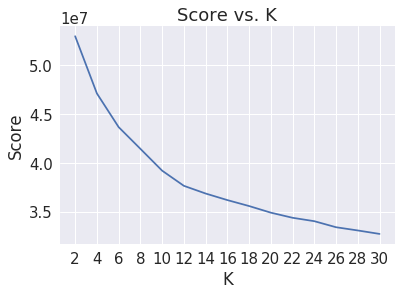

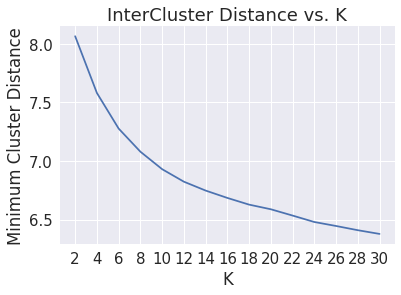

In [31]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# clusterDist = []
# scores = []

# for k in range(2,31,2):
#     old_kmeans = KMeans(n_clusters=k)
#     old_kmeans.fit(scale1)
#     cDist = (np.average(np.min(cdist(scale1, old_kmeans.cluster_centers_, 'euclidean'), axis=1)))
#     clusterDist.append(cDist)
#     score = np.abs(old_kmeans.score(scale1))
#     scores.append(score)
#     print(k," ",score, " added to ",scores) #30 - 558338809
#     print(k," ", cDist, "added to ", clusterDist) #30 - 558338809

ind = list(range(2,31,2))


scores = [52944720.281436771, 47086395.212928377, 43641447.640706591, 41418994.291407518, 39182445.173172794, 37629792.334780321, 36842512.070945196, 36169305.305934504, 35559234.896283686, 34882090.359103359, 34357409.334013812, 34008412.692222588, 33389872.825711515, 33059542.558642846, 32705401.711161237]
clusterDist = [8.0657597996204746, 7.5810133654165686, 7.2769450596046763, 7.0794397059050462, 6.9300568182389952, 6.8232451565415762, 6.7474189160835278, 6.6844975142393004, 6.627270993704971, 6.5876330358464994, 6.5338590351171764, 6.4788398672289693, 6.4447741264842664, 6.4087598379136876, 6.3770215850458678]

# print(scores)
# print(clusterDist)
# print(len(scores))
# print(len(clusterDist))
# print(len(ind))

plt.plot(ind, scores,marker='x');
plt.xlabel('K');
plt.xticks(ind);
plt.ylabel('Score');
plt.title('Score vs. K');
plt.show()

plt.plot(ind,clusterDist,marker='x');
plt.xlabel('K');
plt.xticks(ind)
plt.ylabel('Minimum Cluster Distance');
plt.title('InterCluster Distance vs. K');
plt.show()

kk = 14

In [32]:
# # Re-fit the k-means model with the selected number of clusters and obtain
# # cluster predictions for the general population demographics data.

kmeans = KMeans(kk,random_state=3425)
azdias_clusters = kmeans.fit_predict(scale1)
azdias_cluster_means = kmeans.cluster_centers_
#14x42 shape

### Discussion 3.1: Apply Clustering to General Population

(How many clusters have you decided to segment the population?)

I decided to segment the population into 14 groups. I decided this after plotting K against the score of Kmeans and the minimum intercluster distance. A clear elbow was not present but after 14 clusters - the distance between successive measurements is not much. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [33]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
print(customers.shape)
print(customers.head(n=3))

(191652, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0  

In [34]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers1 = clean_data(customers)
print(customers1.shape)
print(scale1.shape)
print(azdias1.shape)
#scaler = StandardScaler() remove fit
scale_feat = scaler.transform(customers1.values)
scaled_customer = pd.DataFrame(scale_feat, index=customers1.index, columns=customers1.columns)
print(scaled_customer.head(n=3))

(191652, 85)
(782046, 42)
(782046, 85)
   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0               1.18108           1.413824      -1.151067          1.133958   
1               1.18108           1.413824      -1.151067          1.133958   
2               1.18108           1.413824      -1.151067          1.133958   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0       -1.247921              -0.455771         -0.816561   -1.638968   
1       -1.247921               0.261642         -0.816561   -1.638968   
2       -1.247921               0.979056          0.612841   -0.316594   

   RETOURTYP_BK_S  SEMIO_SOZ       ...        LP_FAMILIE_GROB_1.0  \
0        1.062930   0.950199       ...                  -1.092085   
1       -0.309646  -0.594456       ...                  -1.092085   
2        1.062930  -1.109341       ...                   0.915679   

   LP_FAMILIE_GROB_2.0  LP_FAMILIE_GROB_3.0  LP_FAMILIE_GROB_4.0  \
0 

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

A


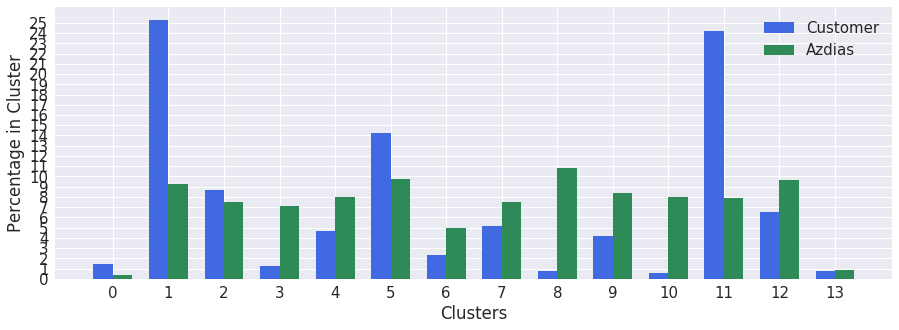

8     0.065993
10    0.070249
3     0.179421
6     0.463111
9     0.504207
4     0.591110
12    0.670331
7     0.686113
13    0.876674
2     1.151724
5     1.456977
1     2.744931
11    3.079030
0     3.652711
dtype: float64
10     0.563000
8      0.717446
13     0.734143
3      1.276793
0      1.483418
6      2.277044
9      4.213366
4      4.694968
7      5.123349
12     6.491975
2      8.695448
5     14.213262
11    24.228811
1     25.286978
Name: Customer, dtype: float64


In [35]:
# # Compare the proportion of data in each cluster for the customer data to the
# # # proportion of data in each cluster for the general population.

scaled_cust = pca1.transform(scaled_customer) #apply dataframe?
cust_clusters = kmeans.predict(scaled_cust)
customer_cluster_means = kmeans.cluster_centers_
#
cust_clusters = pd.Series(cust_clusters)
cust_clusters.rename('Customer',inplace=True)

azdias_clusters = pd.Series(azdias_clusters)
azdias_clusters.rename('Azdias',inplace=True)

custVals =cust_clusters.value_counts().sort_index()
azdiasVals = azdias_clusters.value_counts().sort_index() 

clusterCounts = pd.concat([azdiasVals,custVals],axis=1)
clusterCounts['Azdias'] = clusterCounts['Azdias']/clusterCounts['Azdias'].sum() *100 
clusterCounts['Customer'] = clusterCounts['Customer']/clusterCounts['Customer'].sum() *100 

ind = np.arange(kk)  # the x locations for the groups
width = 0.35 

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind,clusterCounts.Customer,width,color='royalblue')
rects2 = ax.bar(ind+width,clusterCounts.Azdias,width,color='seagreen')

ax.set_ylabel('Percentage in Cluster')
ax.set_xlabel('Clusters')
ax.set_yticks(range(26))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(ind)
#ax.yaxis.grid() 
#ax.set_axisbelow(True)
ax.legend((rects1[0], rects2[0]), ('Customer', 'Azdias') )
plt.show()

# #for col in clusterCounts.columns:

print((clusterCounts['Customer']/clusterCounts['Azdias']).sort_values())
print((clusterCounts['Customer']).sort_values())



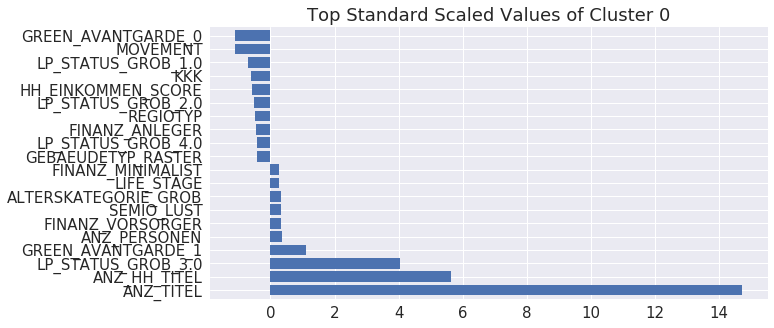

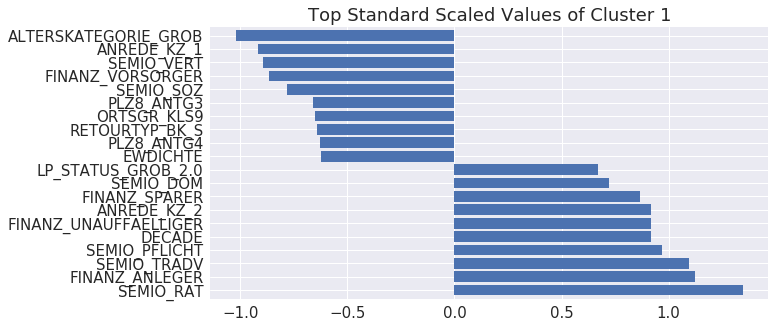

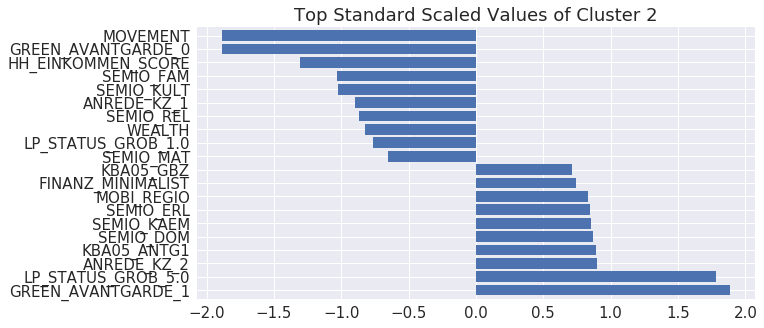

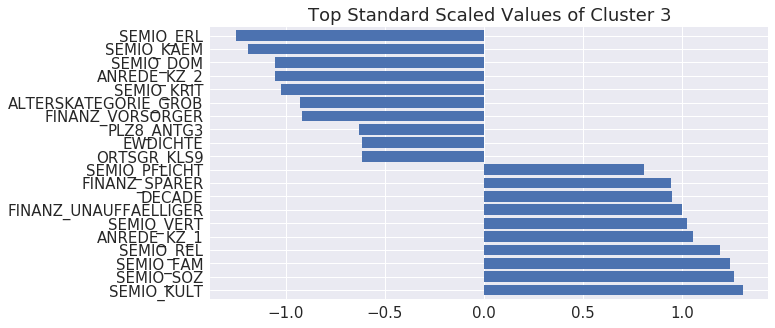

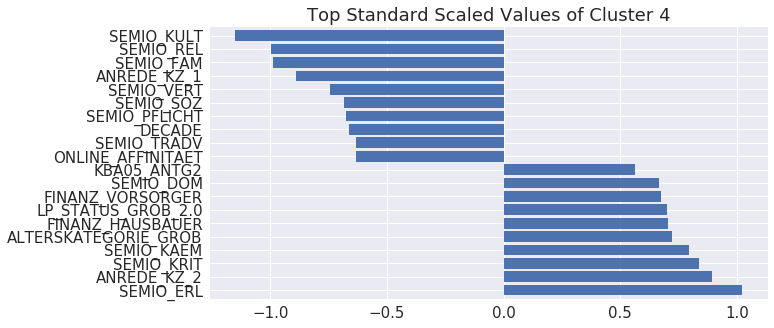

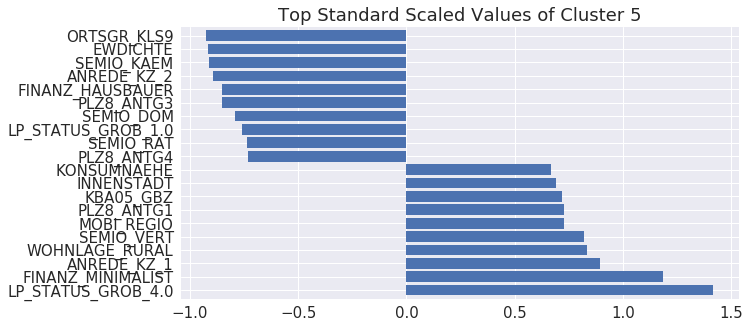

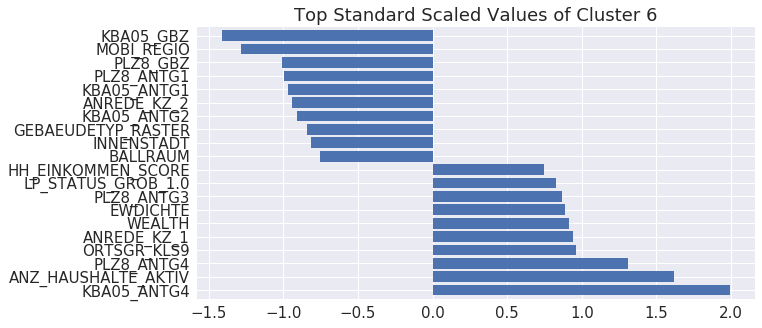

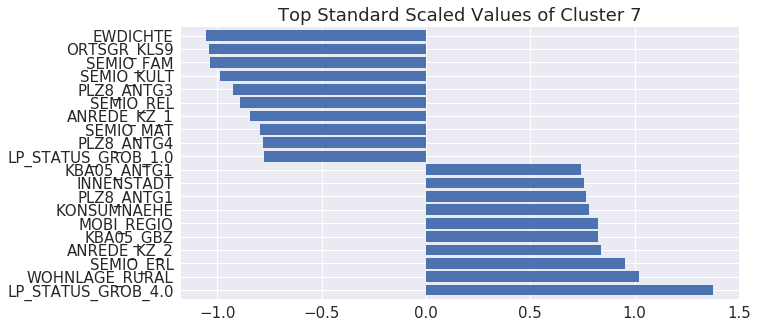

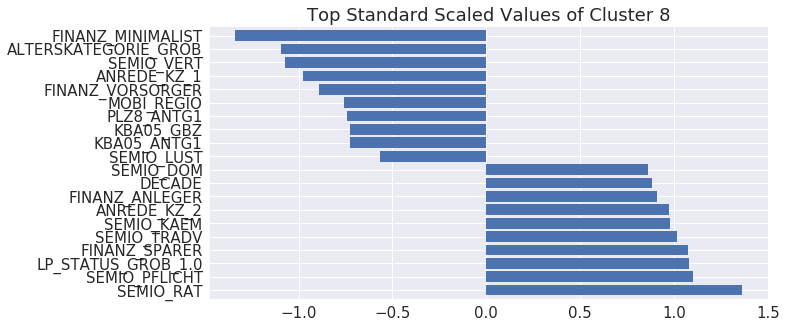

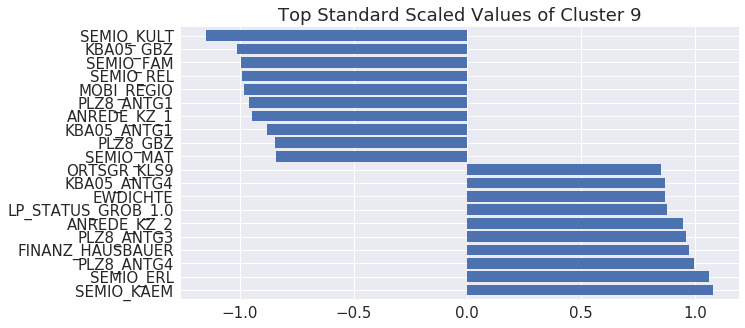

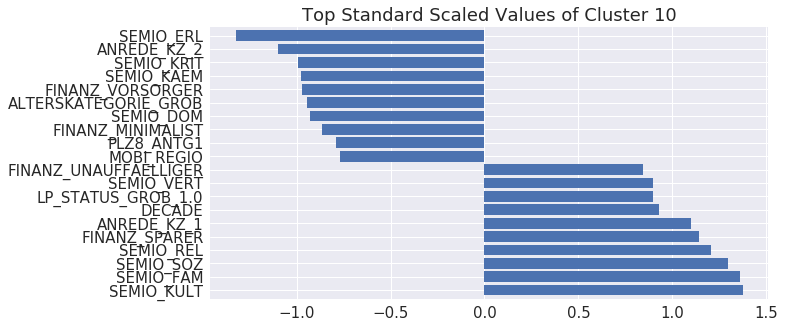

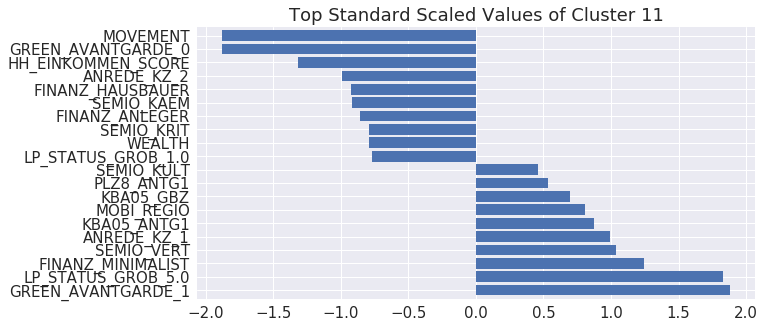

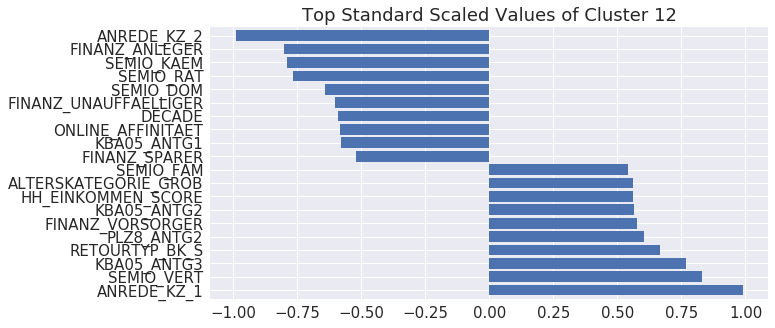

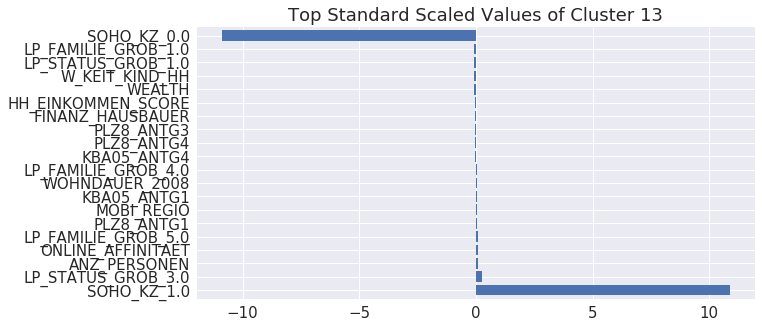

In [36]:
def plot_scaled_comparison(df_sample, kmeans_cluster, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
pca1.inverse_transform(kmeans_cluster[cluster]))), orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    plt.figure(figsize=(10,5))
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh',width=0.8);
    #return pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0)
    plt.title('Top Standard Scaled Values of Cluster ' + str(cluster))
    plt.show()

for i in range(14):#CHANGE 14
    plot_scaled_comparison(customers1,customer_cluster_means, i)
# #strongly negative values suggest lower values on the original scale and positive values suggest higher values on the original scale.    

### Discussion 3.3: Compare Customer Data to Demographics Data

Note:- Low means low number and high means high number on the scale of the attribute. 

The clusters that are underrepresented are 8,10,3

1.) Cluster 8 - 
- Female (HIGH ANREDE_KZ_2, LOW ANREDE_KZ_1)
- Young (HIGH DECADE, LOW ALTERSKATEGORIE_GROB)
- Low income earners (HIGH LP_STATUS_GROB_1.0)
- Less financial interest - in investing or saving but prepared((VERY)LOW FINANZ MINIMALIST, HIGH FINANZ_ANLEGER, FINANZ SPARER, FINANZ_VORSORGER)
- High movement patterns(LOW MOBI_REGIO)

This cluster could be underrepresented by the mail-order company as low-income earners with high movement patterns that are financially prepared (don't invest, save etc.) are less likely to use this company. 


2.)Cluster 10 - 
- Male(HIGH ANREDE_KZ_1, LOW ANREDE_KZ_2)
- Young(HIGH DECADE, LOW ALTERSKATEGORIE_GROB)
- Poor(High LP_STATUS_GROB_1.0)
- Less interest in money. But prepared. (HIGH FINANZ_SPARER, FINANZ_UNAUFFAELLIGER. LOW FINANZ MINIMALIST, LOW FINANZ VORSORGER)
- Critical thinker, combative/dominant.(LOW SEMIO_KRIT,SEMIO_KAEM,SEMIO_DOM)
- Not dreamful, religious, social, family, culture oriented much(HIGH SEMIO_VERT, SEMIO_REL, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT)

This cluster consists of males that are young and poor. They are prepared and critical thinkers so must spend judiciously. 

3.) 
- Male (LOW ANREDE_KZ_2, HIGH ANREDE_KZ_1)
- Young(LOW ALTERSKATEGORIE_GROB,HIGH DECADE)
- Less density of houses in the area/small community size(LOW EWIDTCHE,ORTSGR_KLS9)
- Critical thinking, combative/dominant (LOW SEMIO_KRIT,SEMIO_KAEM, SEMIO_DOM)
- Not interested in dreams, religion, family, society, culture, duty(HIGH SEMIO_VERT, SEMIO_REL, SEMIO_FAM, SEMIO_SOZ,SEMIO_KULT,SEMIO_PFLICHT)

Young population is in general less likely to use a male-order service. 


The clusters that are overrepresented are 0,11 and 1. 

1.) Cluster 1
- Very high purchasing power in region (low KKK)
- There is business in region (High GEBAEUDETYP_RASTER)

- High number of people in the house (espsecially professors/title holding) (High ANZ_TITEL, ANZ_HH_TITEL, ANZ_PERSONNEN)
- On the older side (HIGH ALTERSKATEGORIE GROB)
- Independents, high income (HIGH LP_STATUS_GROB_3.0, LESS LP_STATUS_GROB_1.0/2.0/4.0, HH_EINKOMMEN_SCORE)

This cluster is overrepresented by the company as there is high purchasing power and business in the region. The residents are on the older side, educated and have high income - so they can employ mail-order services. 

2. ) Cluster 11
- Male (HIGH ANREDE_KZ_1, LOW ANREDE_KZ_2)
- Top earners/have house - very rich(HIGH LP_STATUS_GROB_5.0,Low FINANZ_HAUSBAUER, low HH_EINKOMMEN_SCORE, Wealth)
- 1- 2 family homes HIGH KBA-5_ANTG1,PLZ8_ANTG1
- Into investing (LOW FINANZ_ANLEGER)
- Move less (LESS MOVEMENT, HIGH MOBIO_REGIO)

These people are top earners, have houses, move less - so likely to mail-order a lot. 

3. ) Cluster 1
- Female (LOW ANREDE_KZ_1, HIGH ANREDE_KZ_2)
- Young(LOW ALTERSKATEGORIE_GROB, HIGH DECADE)
- Dreamy people (LOW SEMIO_VERT)

- Average earners (HIGH LP_STATUS_GROB_2.0)
- Crazy shoppers or heavy returners (LOW RETOURTYPE_BKS)
- Don't save money(HIGH FINANZ_SPARER)
- Less homes/smaller community (LOW ORTSGR_KLKS9/EWDICHTE)

These women live in less dense communites so probably far away from stores. They don't save money and shop a lot/return heavily - hence, must form a large part of the customer base. 

Clusters 1, 11 and 5 are popular. 1 and 11 are described above. 

Cluster 5:
- House owners, not low-income(Low FINANZ_HAUSBAUER, High LP_STATUS_GROB_4.0, LOW 1.0)
- Live far away from city (HIGH INNENSTADT, WOHNLAGE_RURAL,KONSUMNAEHE)
- Not that crowded(LOW EWDICHTE/ORSGR_KLS9)
- Low movement pattern (HIGH MOBI_REGIO)

- Male(HIGH ANRDE_KZ_1, LOW ANREDE_KZ_2)
- Dominant/combative, rational personality(LOW SEMIO_DOM, SEMIO_KAEM, SEMIO_RAT)
- Financially interested(HIGH FINANZ_MINIMALIST)

This cluster must be popular as they live far away from the city/in a rural area, so likely to mail-order many things. 


In [44]:
# 0,1,3,5,8,10,11

#Cluster 0
data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==0)])).round()
c0 = pd.DataFrame(data=data,index=list(range(data.shape[0])),#np.array(range(0, data.shape[0])),
           columns=azdias1.columns)

with pd.option_context('display.max_columns', 85):
    print("\nCluster 0: ")
    print(c0.head(n=10))
    print(c0.describe())


#Cluster 1
data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==1)])).round()
c1 = pd.DataFrame(data=data,index=list(range(data.shape[0])),columns=azdias1.columns)

with pd.option_context('display.max_columns', 85):
    print("\nCluster 1: ")
    print(c1.head(n=10))
    print(c1.describe())


#Cluster 3
data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==3)])).round()
c3 = pd.DataFrame(data=data,index=list(range(data.shape[0])),columns=azdias1.columns)
with pd.option_context('display.max_columns', 85):
    print("\nCluster 3: ")
    print(c3.head(n=10))
    print(c3.describe())


Cluster 0: 
   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                   3.0                5.0            1.0               5.0   
1                   3.0                5.0            1.0               4.0   
2                   4.0                4.0            1.0               5.0   
3                   4.0                4.0            1.0               5.0   
4                   4.0                5.0            2.0               3.0   
5                   4.0                4.0            1.0               5.0   
6                   3.0                4.0            1.0               5.0   
7                   4.0                4.0            1.0               5.0   
8                   4.0                3.0            1.0               4.0   
9                   4.0                5.0            1.0               5.0   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0             1.0                    2.0   

In [43]:
# # What kinds of people are part of a cluster that is underrepresented in the
# # customer data compared to the general population?

# 5,8,10

#cluster 5
data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==5)])).round()
c5 = pd.DataFrame(data=data,index=list(range(data.shape[0])),columns=azdias1.columns)
with pd.option_context('display.max_columns', 85):
    print("\nCluster 5: ")
    print(c5.head(n=10))
    print(c5.describe())

#cluster 8
data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==8)])).round()
c8 = pd.DataFrame(data=data,index=list(range(data.shape[0])),columns=azdias1.columns)
with pd.option_context('display.max_columns', 85):
    print("\nCluster 8: ")
    print(c8.head(n=10))
    print(c8.describe())
    
#cluster 10

data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==10)])).round()
c10 = pd.DataFrame(data=data,index=list(range(data.shape[0])),columns=azdias1.columns)
with pd.option_context('display.max_columns', 85):
    print("\nCluster 10: ")
    print(c10.head(n=10))
    print(c10.describe())


Cluster 5: 
   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                   3.0                5.0            1.0               5.0   
1                   4.0                5.0            2.0               4.0   
2                   3.0                5.0            2.0               4.0   
3                   2.0                6.0            1.0               5.0   
4                   4.0                5.0            0.0               5.0   
5                   4.0                5.0            1.0               5.0   
6                   3.0                5.0            1.0               5.0   
7                   4.0                5.0            1.0               5.0   
8                   3.0                5.0            1.0               5.0   
9                   3.0                5.0            3.0               3.0   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0             1.0                    1.0   

In [42]:
#11
data = scaler.inverse_transform(pca1.inverse_transform(scaled_cust[np.where(cust_clusters==11)])).round()
c11 = pd.DataFrame(data=data,index=list(range(data.shape[0])),columns=azdias1.columns)
with pd.option_context('display.max_columns', 85):
    print("\nCluster 11: ")
    print(c11.head(n=10))
    print(c11.describe())
    


Cluster 11: 
   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                   4.0                5.0            1.0               5.0   
1                   4.0                5.0            1.0               5.0   
2                   3.0                5.0            1.0               5.0   
3                   3.0                5.0            1.0               5.0   
4                   4.0                5.0            1.0               5.0   
5                   3.0                5.0            2.0               4.0   
6                   3.0                5.0            1.0               5.0   
7                   3.0                5.0            1.0               5.0   
8                   4.0                5.0            1.0               5.0   
9                   4.0                4.0            4.0               2.0   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0             1.0                    2.0  

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.